In [1]:
import sys
sys.path.append("..")

In [2]:
import os

# prevent JAX from preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data loading
import pandas as pd
import numpy as np

# plotting
#import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    # workaround for jax bug on GPUs
    # https://github.com/jax-ml/jax/issues/24909
    jax.config.update("jax_default_matmul_precision", "float32")
    # configure numpyro to use GPU
    numpyro.set_platform("gpu")

from jax.extend.backend import get_backend
print(f"current device: {get_backend().platform}")

import weathergen as wx
import wxsbi

current device: gpu


In [3]:
# enable autoreload of source files
%load_ext autoreload
%autoreload 2

# Data

In [4]:
import weathergen.data

name_map = weathergen.data.data_var_name_map(prec="pr", Tair_mean="tavg", Tair_min="tmin", Tair_max="tmax", time = "date")
dataset = wx.data.load_time_series_csv("../data/potsdam.csv", name_map)

# Choose training period
calibration_data = dataset["1950":"1999"]

# Remove two datapoints where Tmin == Tavg
calibration_data = calibration_data.drop(index=calibration_data.iloc[[6579, 6994], :].index)

In [5]:
assert np.all(calibration_data["Tair_min"] < calibration_data["Tair_mean"])
assert np.all(calibration_data["Tair_min"] < calibration_data["Tair_max"])
assert np.all(calibration_data["Tair_mean"] < calibration_data["Tair_max"])
assert np.all(calibration_data["prec"] >= 0)

# Model

In [6]:
from weathergen.wgen.wgen_gamlss import *

In [7]:
wgen = wx.WGEN(calibration_data, model = WGEN_GAMLSS(), order = 2, Tair_freqs=[1/365.25, 2/365.25], prec_freqs=[1/365.25, 2/365.25])

Run variational inference for parameter estimates:

In [8]:
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoMultivariateNormal

num_iter = 50_000
prng = random.PRNGKey(1234)
guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
#guide = AutoNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)

svi_result = wgen.fit(num_iter, guide, subsample_time=1000, rng=prng)


100%|██████████| 50000/50000 [01:16<00:00, 654.59it/s, init loss: 5652193.0000, avg. loss [47501-50000]: 44089.2578]


Get posterior samples:

In [9]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=1000)
posterior_params = posterior_sampler(prng)
{k: v.mean(axis=0) for k,v in posterior_params.items() if k != "_auto_latent"}

{'Tavg_loc_lag': Array([-0.14746101,  0.91280067], dtype=float32),
 'Tavg_loc_pred': Array([2.3717031], dtype=float32),
 'Tavg_loc_scale_pred': Array([0.7969069], dtype=float32),
 'Tavg_loc_scale_seasonal': Array([ 0.07562284, -0.0447648 ,  0.04190811,  0.0846374 ], dtype=float32),
 'Tavg_loc_seasonal': Array([-0.667298  ,  0.10684851, -2.6650677 ,  0.16250956], dtype=float32),
 'Tavg_loc_seasonal_lag_interaction': Array([-0.01134208,  0.02625033, -0.00886484,  0.00325981,  0.03837875,
        -0.01491038,  0.06220222, -0.00227213], dtype=float32),
 'Trange_disp_lag': Array([0.01388818, 0.09810804], dtype=float32),
 'Trange_disp_lag_seasonal_interaction': Array([-0.05003851, -0.03008706,  0.1099513 , -0.02330322, -0.02404142,
         0.05235722, -0.01986126, -0.02358462], dtype=float32),
 'Trange_disp_pred': Array([-0.25257635], dtype=float32),
 'Trange_disp_seasonal': Array([ 0.06121286, -0.02323655,  0.05571753, -0.22324459], dtype=float32),
 'Trange_mean_Tavg': Array([0.6180875], d

Get predictive distributions and run simulations

In [10]:
svi_predictive = Predictive(wgen.simulate, posterior_samples=posterior_params, parallel=True)
svi_preds = svi_predictive(prng)

In [11]:
obs = wgen.obs

In [12]:
from weathergen.plotting import *

In [13]:
obs["Tmin"] = obs["Tavg"] - obs["Trange"] * obs["Tskew"]
obs["Tmax"] = obs["Tmin"] + obs["Trange"]

## Model diagnostics

In [14]:
sns.color_palette("Purples_d", 4) # Dark2, Reds, Purples, crest, flare

[(0.6551633986928105, 0.6405228758169934, 0.8091503267973856),
 (0.5338562091503267, 0.5019607843137255, 0.7359477124183006),
 (0.41856209150326795, 0.38614379084967315, 0.5994771241830065),
 (0.30928104575163395, 0.2930718954248366, 0.39973856209150327)]

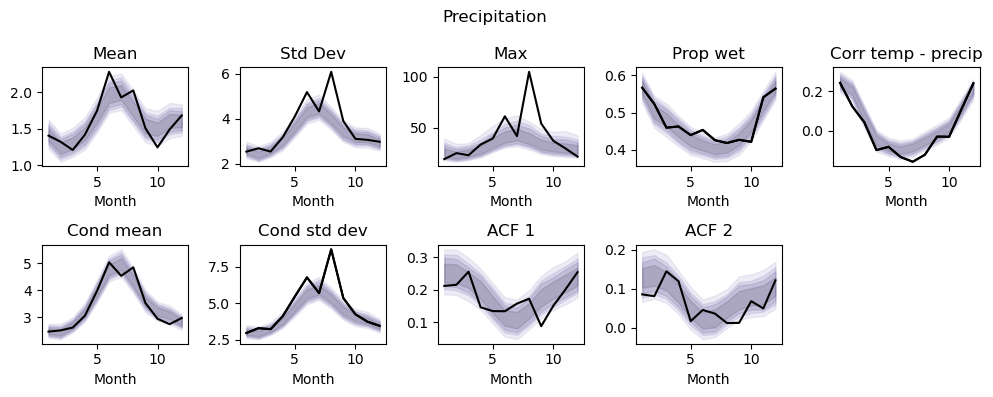

In [15]:
fig = plt.figure(layout="tight", figsize=(10, 4))
fig.suptitle("Precipitation")

gs = GridSpec(2, 5, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(5)]
get_mean_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_max_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[2], colors = color_palette)
get_prop_wet_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[3], colors = color_palette)
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[4], colors = color_palette)



# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(5)]
get_cond_mean_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_2[0], colors = color_palette)
get_cond_std_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_acf_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_2[2], lag=1, colors = color_palette)
get_acf_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_2[3], lag=2, colors = color_palette)
ax_row_2[4].axis("off")

plt.savefig("plots/wgen_diagnostics/pr_paper.png", dpi = 300)
plt.savefig("plots/wgen_diagnostics/pr_paper.pdf", dpi = 300)

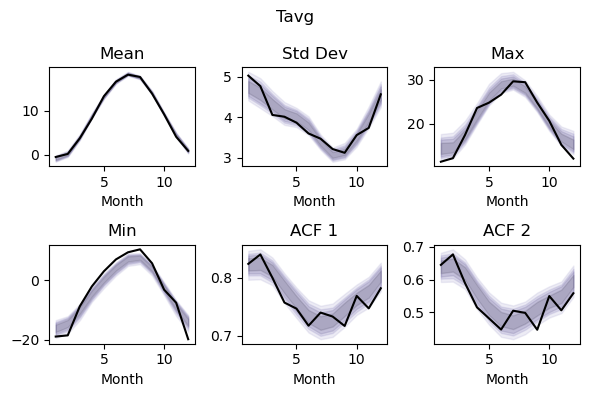

In [16]:
fig = plt.figure(layout="tight", figsize=(6, 4))
fig.suptitle("Tavg")

gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_max_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_1[2], colors = color_palette)

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_min_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_2[0], colors = color_palette)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_2[1], lag=1, colors = color_palette)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_2[2], lag=2, colors = color_palette)

plt.savefig("plots/wgen_diagnostics/tavg_paper.png", dpi = 300)
plt.savefig("plots/wgen_diagnostics/tavg_paper.pdf", dpi = 300)

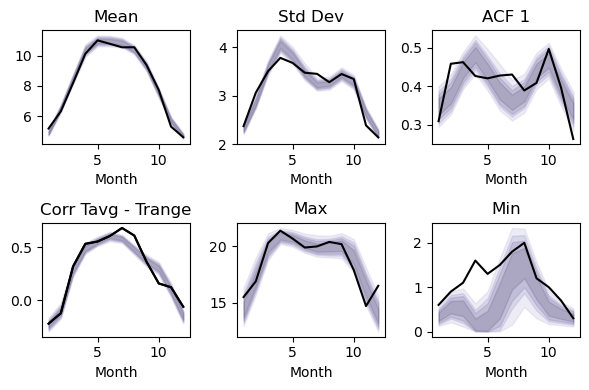

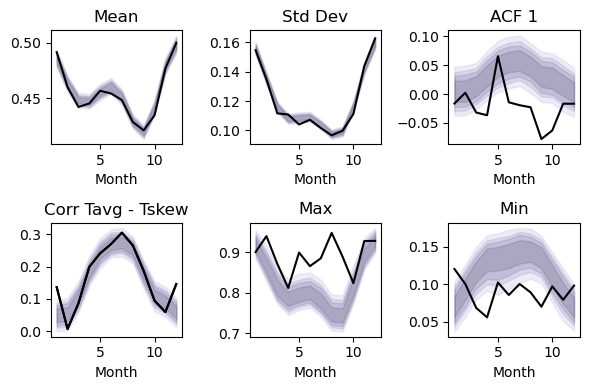

In [17]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Trange")

gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_acf_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_1[2], lag=1, colors = color_palette)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"], svi_preds["Trange"], calibration_data.index,  "Tavg", "Trange", ax=ax_row_2[0], colors = color_palette)
#get_acf_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_min_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_2[2], colors = color_palette)

plt.savefig("plots/trange_paper.png", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tskew")
gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_acf_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_1[2], lag=1, colors = color_palette)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Tskew"], svi_preds["Tskew"], calibration_data.index, "Tavg", "Tskew", ax=ax_row_2[0], colors = color_palette)
#get_acf_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_min_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_2[2], colors = color_palette)

plt.savefig("plots/wgen_diagnostics/tskew_paper.png", dpi = 300)
plt.savefig("plots/wgen_diagnostics/tskew_paper.pdf", dpi = 300)

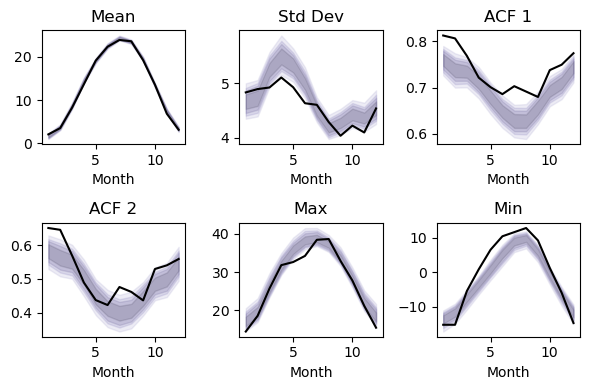

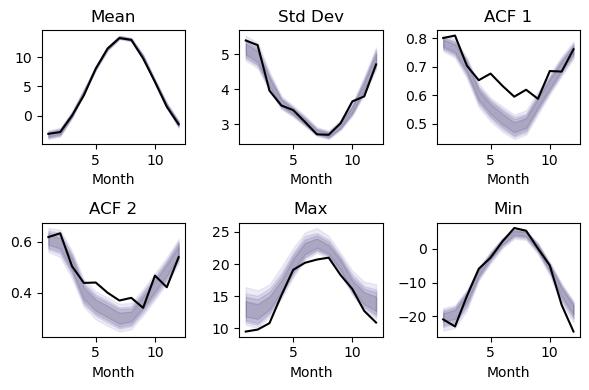

In [18]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmax")

gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_1[2], lag=1, colors = color_palette)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_2[0], lag=2, colors = color_palette)
get_max_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_min_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_2[2], colors = color_palette)

plt.savefig("plots/wgen_diagnostics/tmax_paper.png", dpi = 300)
plt.savefig("plots/wgen_diagnostics/tmax_paper.pdf", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmin")
gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_1[2], lag=1, colors = color_palette)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_2[0], lag=2, colors = color_palette)
get_max_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_min_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_2[2], colors = color_palette)

plt.savefig("plots/wgen_diagnostics/tmin_paper.png", dpi = 300)
plt.savefig("plots/wgen_diagnostics/tmin_paper.pdf", dpi = 300)

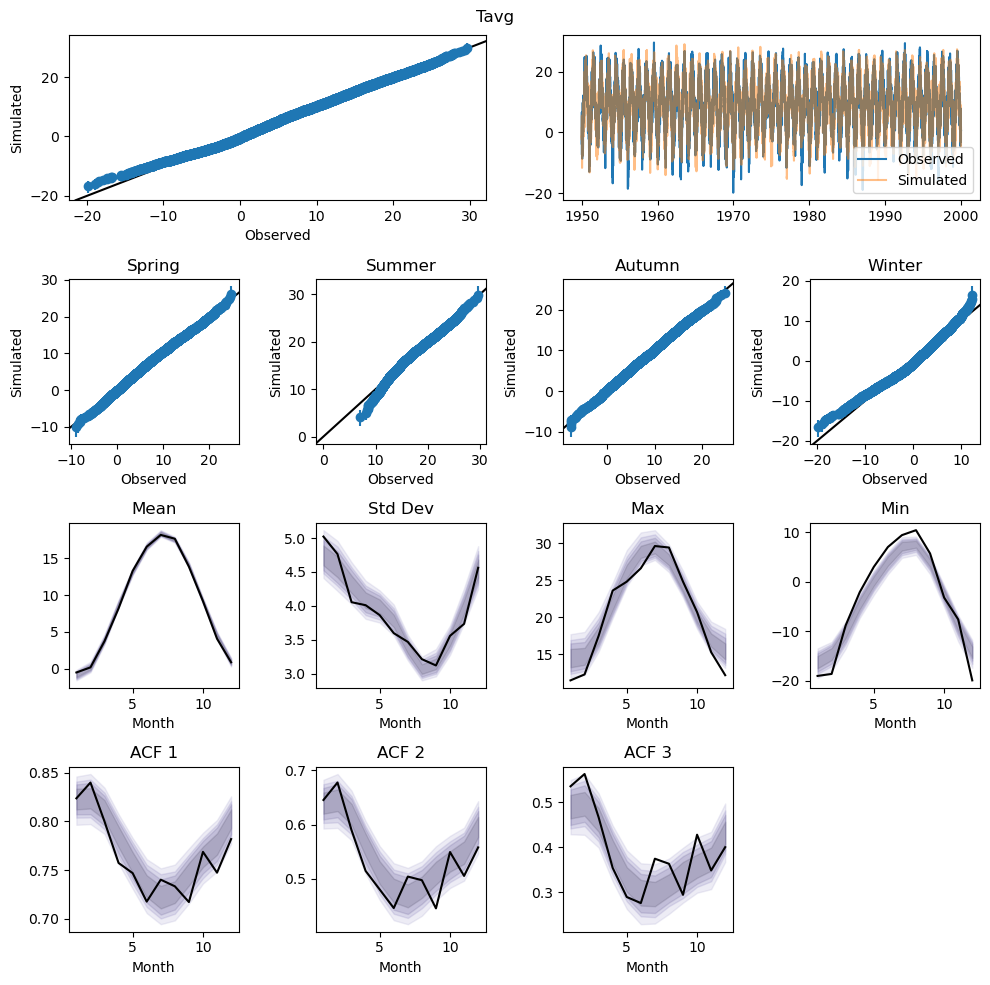

In [19]:
Tavg_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_diagnostics/wgen_Tavg.png")

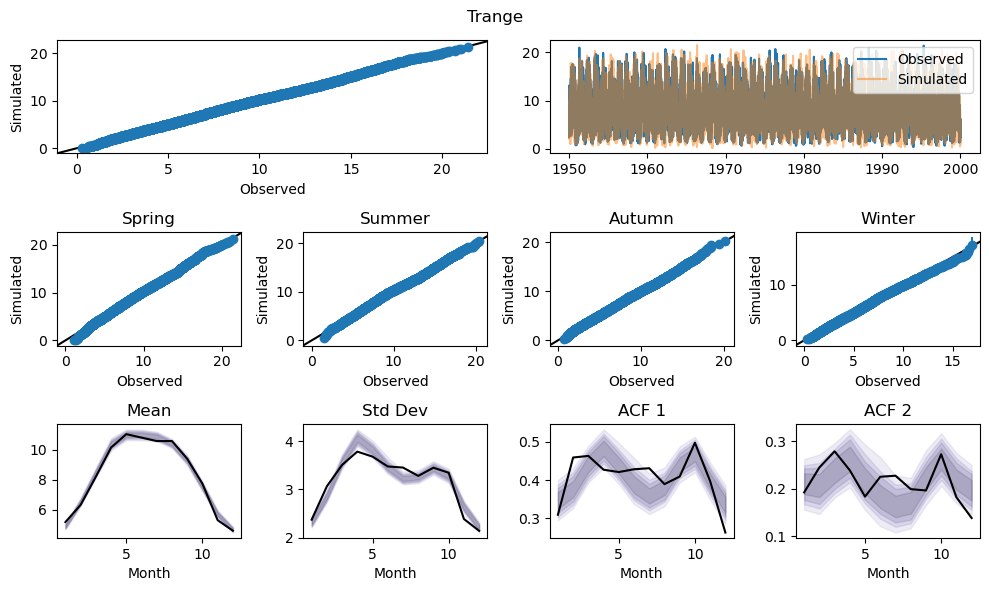

In [20]:
Trange_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_diagnostics/wgen_Trange.png")

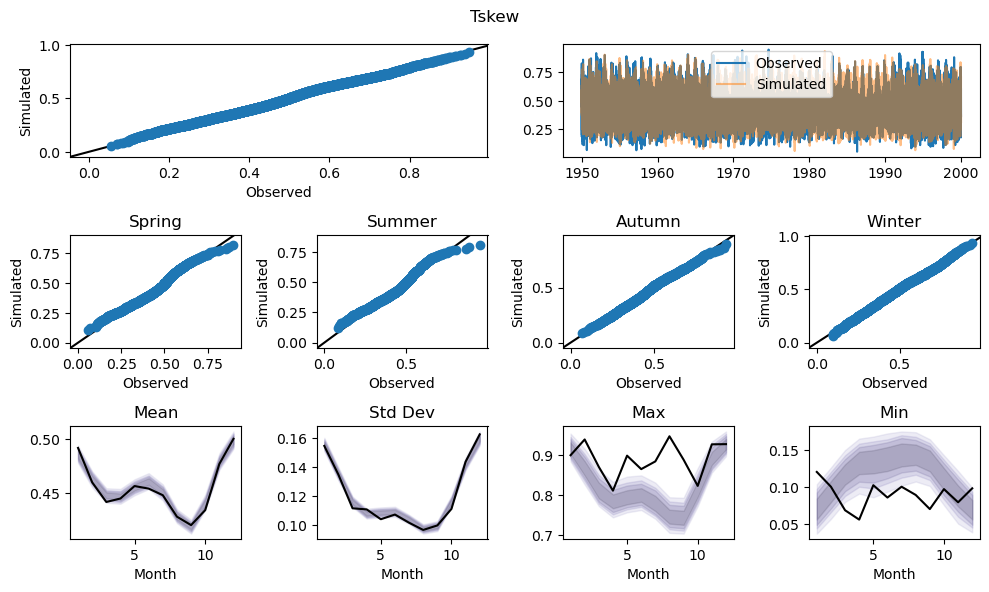

In [21]:
Tskew_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_diagnostics/wgen_Tskew.png")

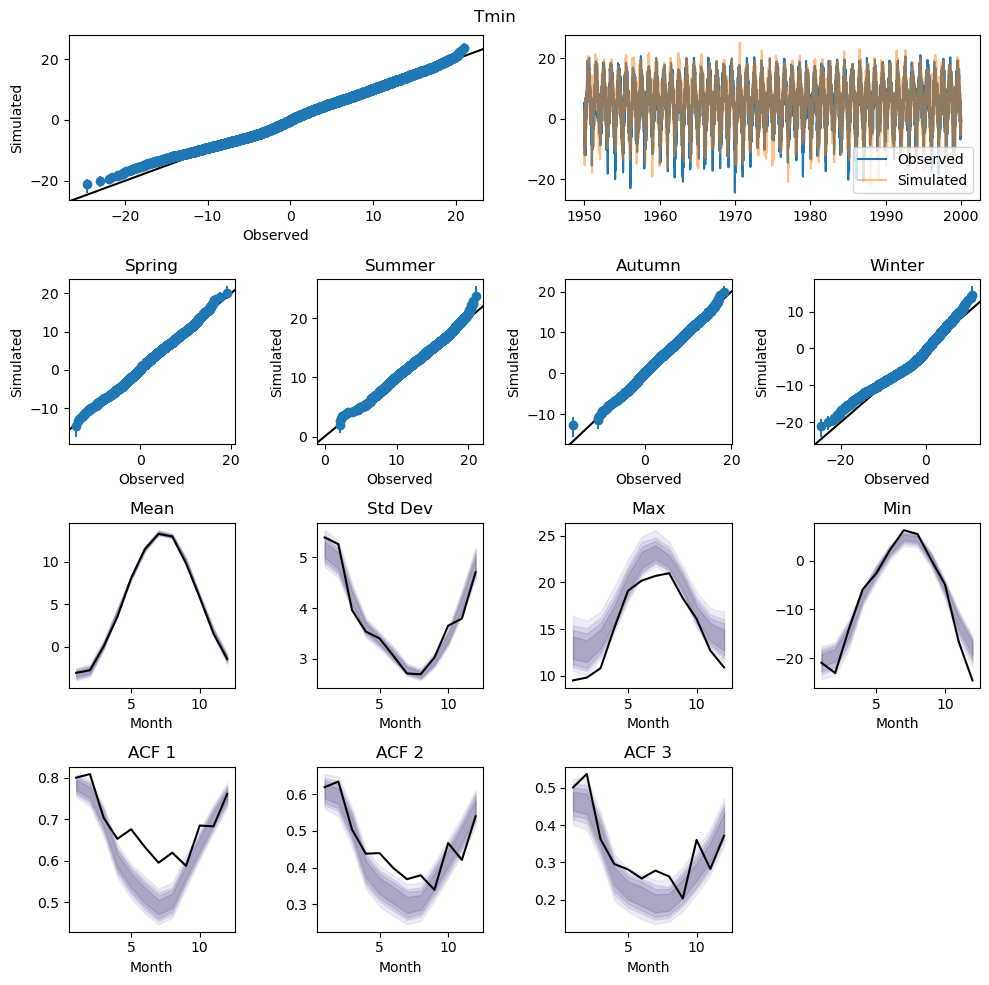

In [22]:
Tmin_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_diagnostics/wgen_Tmin.png")

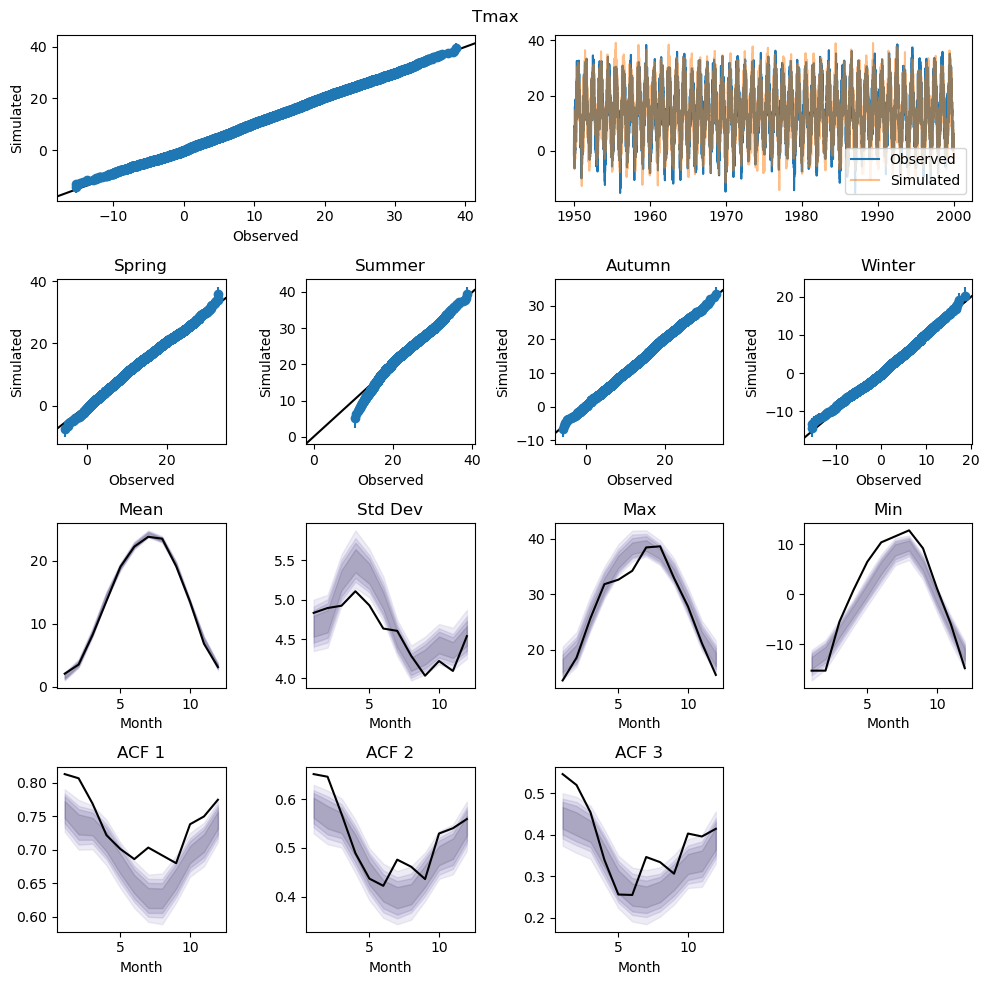

In [23]:
Tmax_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_diagnostics/wgen_Tmax.png")

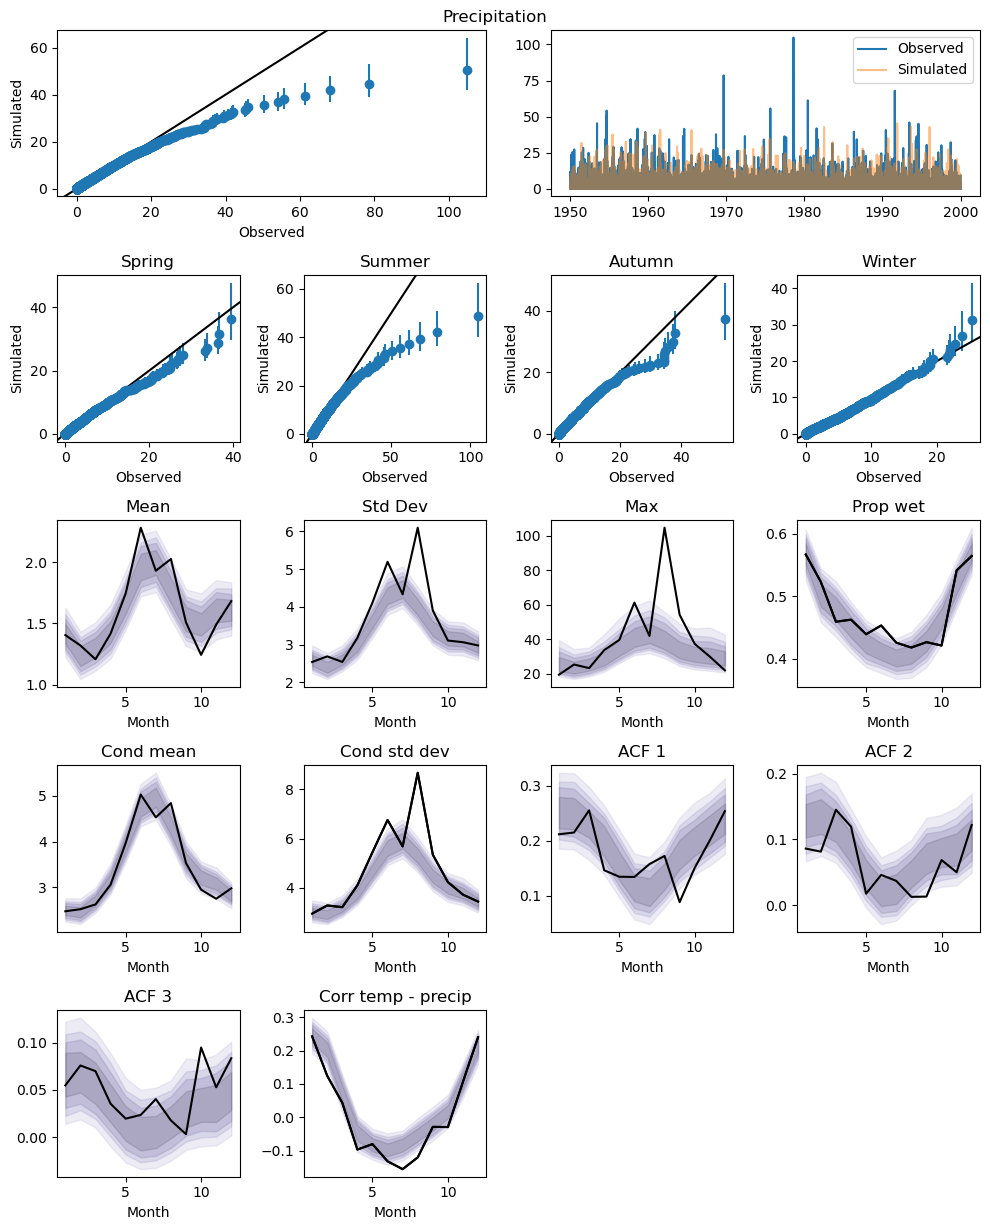

In [24]:
prec_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_diagnostics/wgen_prec.png")

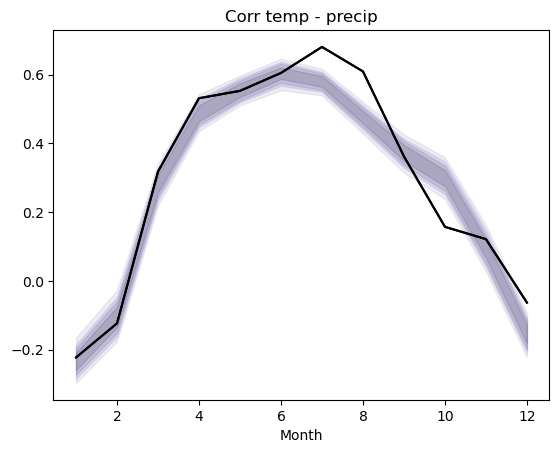

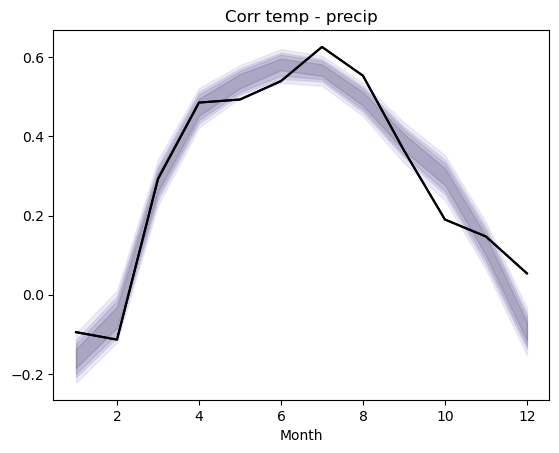

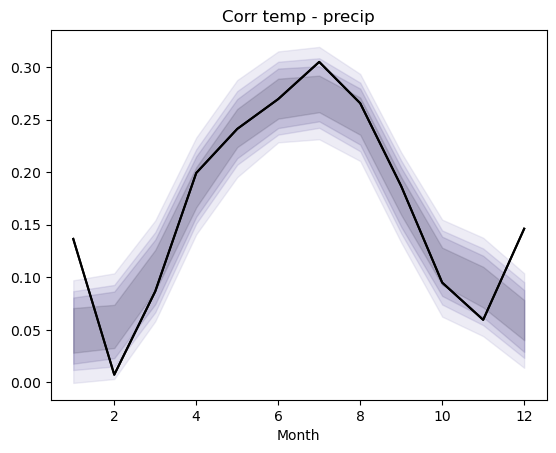

In [25]:
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"], svi_preds["Trange"], calibration_data.index, colors = color_palette)
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"]*obs["Tskew"], svi_preds["Trange"]*svi_preds["Tskew"], calibration_data.index, colors = color_palette)
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Tskew"], svi_preds["Tskew"], calibration_data.index, colors = color_palette)

# SBI

In [26]:
import torch
torch.manual_seed(1234)

In [27]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Case study 1a (Tavg, pr, dry days const.):

Trend in tavg, precip, dry days constant:

In [28]:
num_rounds = 10
num_simulations_per_round = 1000
batch_size = 1000

In [29]:
@wxsbi.summarystats("pmean", "pavgwet", "Tavgmean")
def case_study_1a(prec, Tavg, **kwargs):
    pmean = jnp.mean(prec, axis = -1)
    pavgwet = jnp.mean(prec > 0, axis = -1)
    Tavgmean = jnp.mean(Tavg, axis = -1)
    return jnp.stack([pmean, pavgwet, Tavgmean], axis = -1)

In [30]:
obs_stats_1a = case_study_1a(**obs).flatten()
obs_stats_1a

Array([1.6045674, 0.4748631, 8.81644  ], dtype=float32)

In [31]:
obs_stats_target_1a = obs_stats_1a
obs_stats_target_1a = obs_stats_target_1a.at[0].mul(1.2) # 20% more precip
obs_stats_target_1a = obs_stats_target_1a.at[2].add(3.5) # +3.5 degC avg temp.
obs_stats_target_1a

Array([ 1.925481 ,  0.4748631, 12.31644  ], dtype=float32)

In [32]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew", "precip_occ_"])

simulator = wxsbi.build_simulator(wgen, case_study_1a, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask = parameter_mask, scale_factor = 2.5)

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean


100%|██████████| 2/2 [00:28<00:00, 14.08s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:27<00:00, 13.83s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:27<00:00, 13.93s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi.wxsbi:Training estimator


 Neural network successfully converged after 110 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 106 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

INFO:wxsbi.wxsbi:Starting round 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.

INFO:wxsbi.wxsbi:Starting round 6/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

INFO:wxsbi.wxsbi:Starting round 7/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 70 epochs.

INFO:wxsbi.wxsbi:Starting round 8/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 32

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 33 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 21

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 22 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.18s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.06s/it]


6.326114098230998


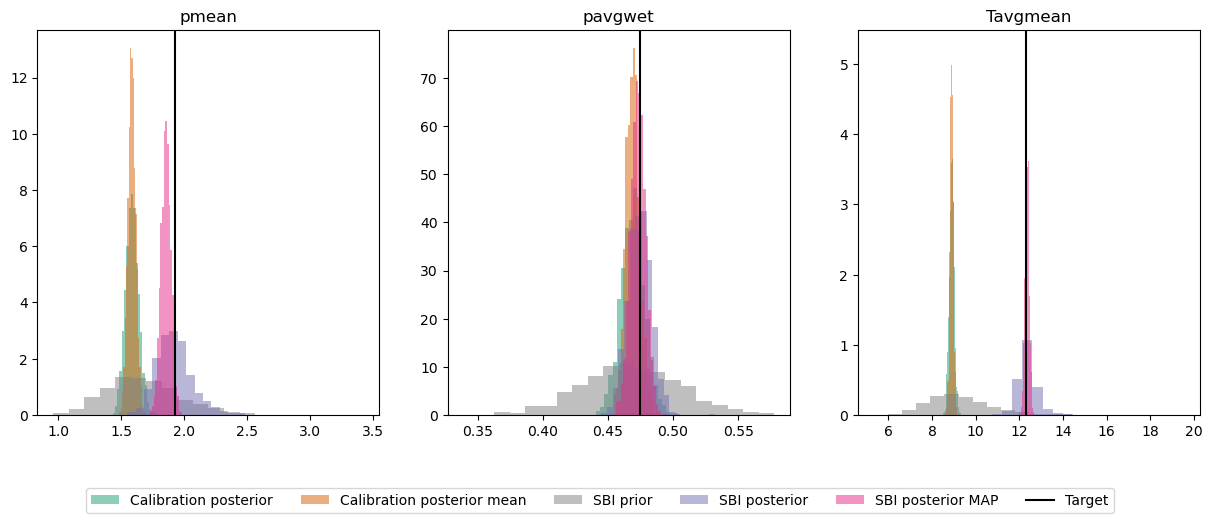

In [33]:
result = wxsbi.run_sbi(simulator, obs_stats_target_1a, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params),
                       num_samples = 2000, num_rounds = num_rounds, batch_size = batch_size,
                       simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_1a.pkl")

## Case study 1b (as 1a but dry day prior scaled up, not included in paper):

Trend in tavg, precip, dry days constant:

In [34]:
num_rounds = 10
num_simulations_per_round = 1000
batch_size = 1000

In [35]:
obs_stats_1b = case_study_1a(**obs).flatten()
obs_stats_1b

Array([1.6045674, 0.4748631, 8.81644  ], dtype=float32)

In [36]:
obs_stats_target_1b = obs_stats_1b
obs_stats_target_1b = obs_stats_target_1b.at[0].mul(1.2)
obs_stats_target_1b = obs_stats_target_1b.at[2].add(3.5)
obs_stats_target_1b

Array([ 1.925481 ,  0.4748631, 12.31644  ], dtype=float32)

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:28<00:00, 14.33s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.06s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.09s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 100 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 132 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.

INFO:wxsbi.wxsbi:Starting round 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 47

INFO:wxsbi.wxsbi:Starting round 5/10


 Neural network successfully converged after 48 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

INFO:wxsbi.wxsbi:Starting round 6/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 29

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 30 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 57

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 58 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 29

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 30 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 53

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 54 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.44s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.15s/it]


6.451500777403513


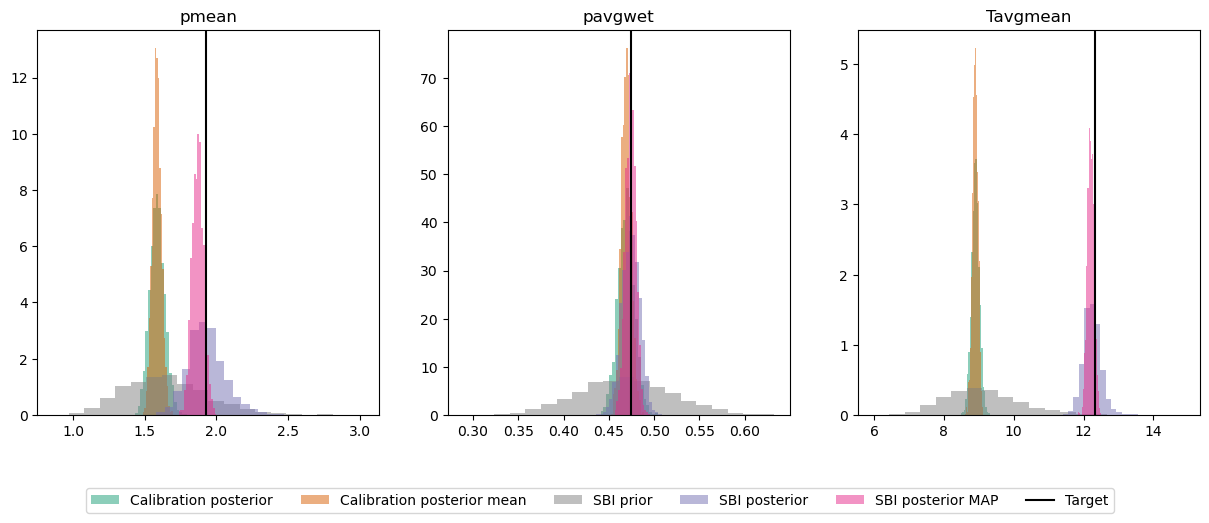

In [37]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_1a, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask)
result = wxsbi.run_sbi(simulator, obs_stats_target_1b, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_1b.pkl")

## Case study 2 (Tavg, pr, heavy rain, icy days, tropical night, Trange)

Note: $\gamma = 3.5$ here to make sure prior closer to target in statistic nr. 5 (tropical nights).

In [38]:
num_rounds = 10
num_simulations_per_round = 1000
batch_size = 1000

In [39]:
obs

{'prec': Array([[ 1.8, 11.1,  1. , ...,  0. ,  0.6,  0. ]], dtype=float32),
 'Tavg': Array([[-3.7,  0.4,  2.1, ...,  0.4,  0.4,  0.5]], dtype=float32),
 'Trange': Array([[4.2, 5.2, 2.3, ..., 2.4, 3. , 3. ]], dtype=float32),
 'Tskew': Array([[0.45238096, 0.8269231 , 0.39130434, ..., 0.375     , 0.46666667,
         0.36666667]], dtype=float32),
 'Tmax': Array([[-1.4000001,  1.3000002,  3.5      , ...,  1.9000001,  2.       ,
          2.4      ]], dtype=float32),
 'Tmin': Array([[-5.6      , -3.8999996,  1.1999999, ..., -0.5      , -1.       ,
         -0.6      ]], dtype=float32)}

In [40]:
@wxsbi.summarystats("Tavgmean", "pmean", "heavy_rain", "icy_days", "tropical_nights", "Trangemean")
def case_study_2(prec, Tmin, Tavg, Tmax, **kwargs):
    Tavgmean = jnp.mean(Tavg, axis = -1)
    
    pmean = jnp.mean(prec, axis = -1)
    heavy_rain = jnp.mean(prec > 20, axis = -1)

    icy_days = jnp.mean(Tmax < 0, axis = -1)
    tropical_nights = jnp.mean(Tmin > 20, axis = -1)

    Trangemean = jnp.mean(Tmax - Tmin, axis = -1)

    return jnp.stack([Tavgmean, pmean, heavy_rain, icy_days, tropical_nights, Trangemean], axis = -1)

obs_stats_2 = case_study_2(**obs).flatten()
obs_stats_2

Array([8.8164396e+00, 1.6045674e+00, 7.2289160e-03, 6.6538885e-02,
       8.2146772e-04, 8.3253994e+00], dtype=float32)

In [41]:
obs_stats_target_2 = obs_stats_2
obs_stats_target_2 = obs_stats_target_2.at[0].add(3.1) # Tavg 
obs_stats_target_2 = obs_stats_target_2.at[1].mul(1.3) # pmean 
obs_stats_target_2 = obs_stats_target_2.at[2].mul(2.) # heavy_rain
obs_stats_target_2 = obs_stats_target_2.at[3].set(0.01) # icy_days: 3 per year
obs_stats_target_2 = obs_stats_target_2.at[4].set(0.08) # tropical_nights: 30 per year
obs_stats_target_2 = obs_stats_target_2.at[5].mul(1.2) # Trangemean
obs_stats_target_2

Array([1.1916439e+01, 2.0859375e+00, 1.4457832e-02, 9.9999998e-03,
       7.9999998e-02, 9.9904795e+00], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:28<00:00, 14.08s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.08s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.48s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 159 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 75 epochs.

INFO:wxsbi.wxsbi:Starting round 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 100 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

INFO:wxsbi.wxsbi:Starting round 6/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 44

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 45 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 62

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 63 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 25

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 26 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 54

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 55 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.38s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.49s/it]


6.7821186224619545


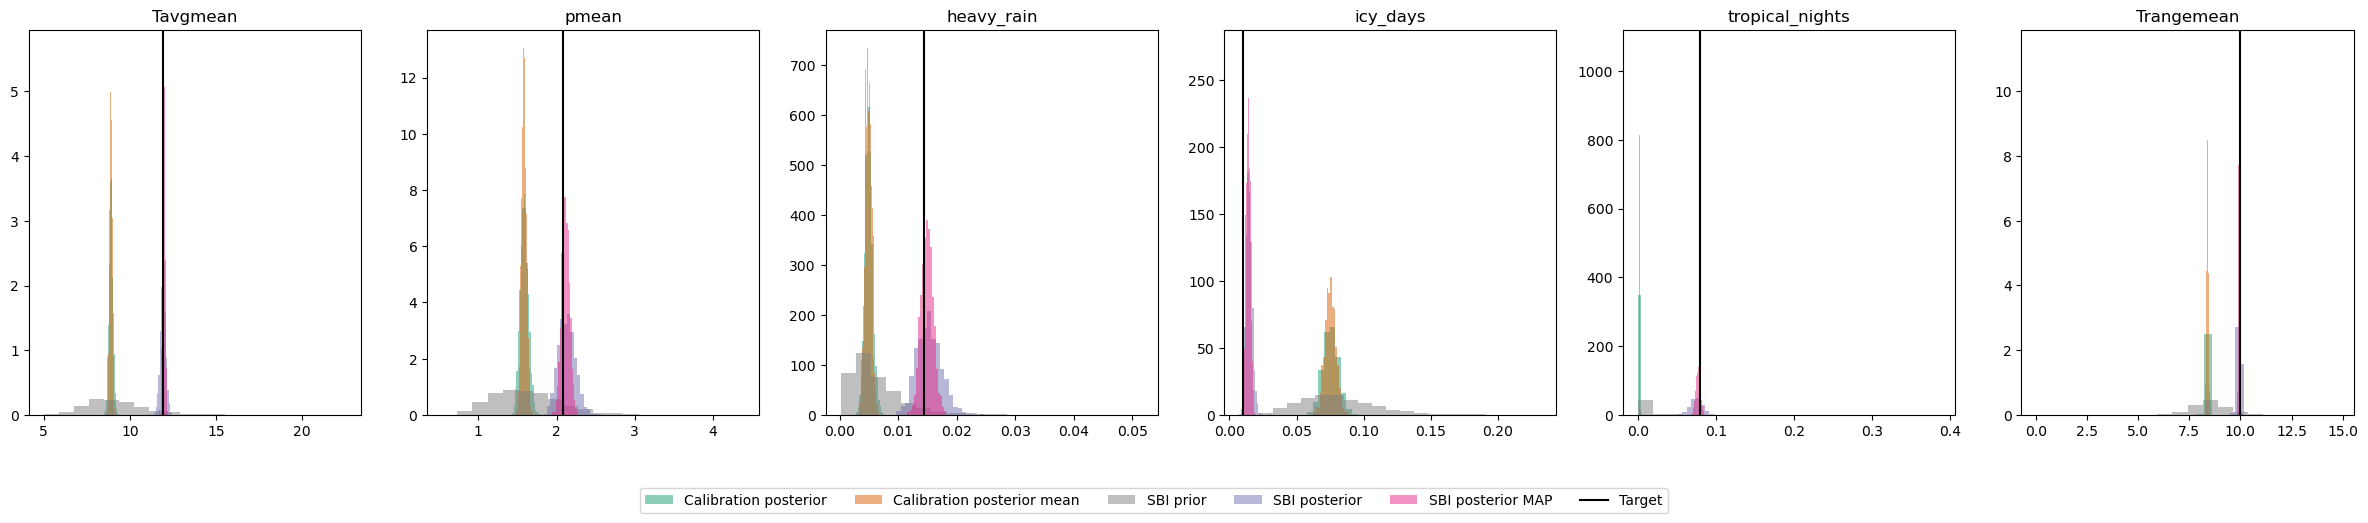

In [42]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["seasonal"])

simulator = wxsbi.build_simulator(wgen, case_study_2, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 3.5)
result = wxsbi.run_sbi(simulator, obs_stats_target_2, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params),
                       num_samples = 2000, num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_2.pkl")

## Case study 3a (seasonal Tavg, pr, monthly dry days const)

In [43]:
num_rounds = 10
num_simulations_per_round = 1000
batch_size = 1000

In [44]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", *list(map(str, range(1,13))))
def case_study_3a(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    wet = (prec > 0)
    
    monthly_pavg_wet = []
    for i in range(1, 13):
        month = (t[:, :, 2] == i)
        pavgwet_month = jnp.nanmean(jnp.where(month, wet, jnp.nan), axis = -1)
        monthly_pavg_wet.append(pavgwet_month)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, *monthly_pavg_wet], axis = -1)#, icy_days])

obs_stats_3a = case_study_3a(t = svi_preds['t'][:, :, :, :], **obs).mean(axis = 0).flatten()
obs_stats_3a.shape

(20,)

In [45]:
obs_stats_target_3a = obs_stats_3a
obs_stats_target_3a = obs_stats_target_3a.at[0].mul(1.3) # pmean winter
obs_stats_target_3a = obs_stats_target_3a.at[1].mul(1.3) # pmean spring
obs_stats_target_3a = obs_stats_target_3a.at[2].mul(1.) # pmean summer
obs_stats_target_3a = obs_stats_target_3a.at[3].mul(1.15) # pmean autumn

obs_stats_target_3a = obs_stats_target_3a.at[4].add(3.4) # Tavg winter
obs_stats_target_3a = obs_stats_target_3a.at[5].add(2.6) # Tavg spring
obs_stats_target_3a = obs_stats_target_3a.at[6].add(3.1) # Tavg summer
obs_stats_target_3a = obs_stats_target_3a.at[7].add(4.5) # Tavg autumn

obs_stats_target_3a

Array([ 1.9140847 ,  1.8918679 ,  2.075413  ,  1.6220818 ,  3.5786033 ,
       11.008175  , 20.57531   , 13.537079  ,  0.5668174 ,  0.5230332 ,
        0.45935467,  0.4626666 ,  0.43935487,  0.45333314,  0.42580634,
        0.41806442,  0.42666656,  0.4212904 ,  0.54133326,  0.5645161 ],      dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:27<00:00, 13.99s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.00s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.10s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 183 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 60

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 61 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 40

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 41 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 48

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 49 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 33

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 34 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 57

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 58 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 33

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 34 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.17s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.13s/it]


6.377997140089671


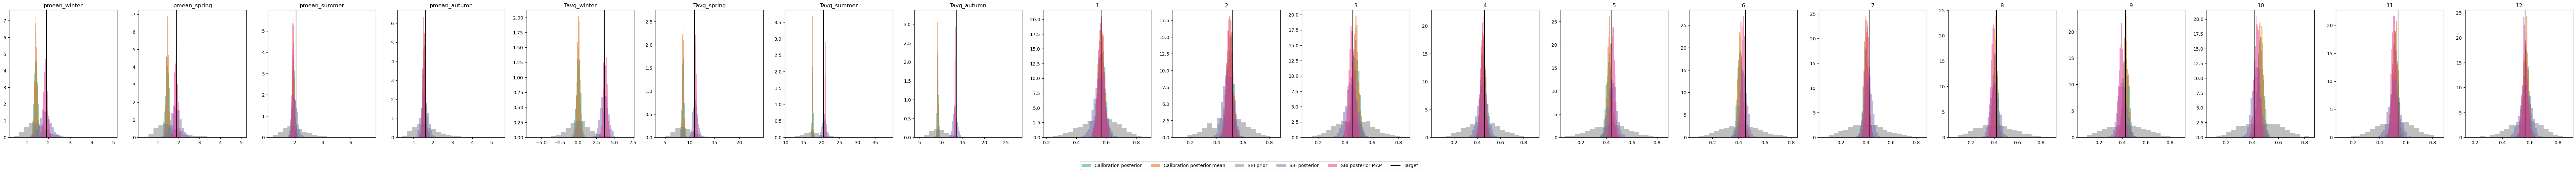

In [46]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_3a, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target_3a, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3a.pkl")

## Case study 3b (seasonal Tavg, pr, overall dry days const, tight prior)

In [47]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", "pavg_wet")
def case_study_3b(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    wet = (prec > 0)
    pavg_wet = jnp.nanmean(wet, axis = -1)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, pavg_wet], axis = -1)#, icy_days])

obs_stats_3b = case_study_3b(
    t = svi_preds['t'][:, :, :, :], 
    prec = jnp.broadcast_to(obs['prec'], (svi_preds['t'].shape[0], obs['prec'].shape[1])),
    Tavg = jnp.broadcast_to(obs['Tavg'], (svi_preds['t'].shape[0], obs['Tavg'].shape[1]))
    ).mean(axis = 0).flatten()
obs_stats_3b

Array([ 1.4723729 ,  1.455283  ,  2.075413  ,  1.4105059 ,  0.17860313,
        8.4081745 , 17.47531   ,  9.037079  ,  0.4748631 ], dtype=float32)

In [48]:
obs_stats_target_3b = obs_stats_3b
obs_stats_target_3b = obs_stats_target_3b.at[0].mul(1.3) # pmean winter
obs_stats_target_3b = obs_stats_target_3b.at[1].mul(1.3) # pmean spring
obs_stats_target_3b = obs_stats_target_3b.at[2].mul(1.) # pmean summer
obs_stats_target_3b = obs_stats_target_3b.at[3].mul(1.15) # pmean autumn

obs_stats_target_3b = obs_stats_target_3b.at[4].add(3.4) # Tavg winter
obs_stats_target_3b = obs_stats_target_3b.at[5].add(2.6) # Tavg spring
obs_stats_target_3b = obs_stats_target_3b.at[6].add(3.1) # Tavg summer
obs_stats_target_3b = obs_stats_target_3b.at[7].add(4.5) # Tavg autumn

obs_stats_target_3b

Array([ 1.9140847,  1.8918679,  2.075413 ,  1.6220818,  3.5786033,
       11.008175 , 20.57531  , 13.537079 ,  0.4748631], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:27<00:00, 13.91s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.45s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.04s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 142 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 57

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 58 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 76 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 24

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 25 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 30

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 31 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 38

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 39 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 24

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 25 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 49

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 50 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.10s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.03s/it]


6.1995064377784725


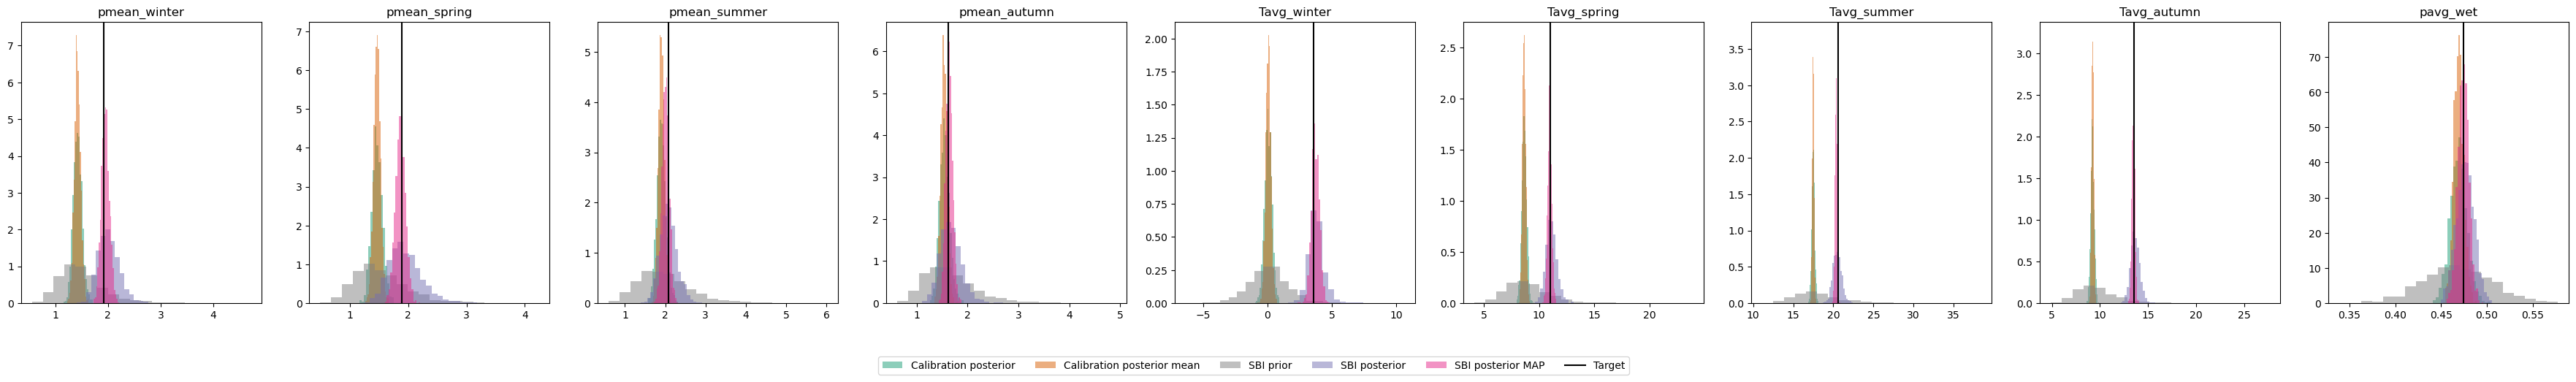

In [49]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew", "precip_occ_"])

simulator = wxsbi.build_simulator(wgen, case_study_3b, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target_3b, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3b.pkl")

## Case study 3c (seasonal Tavg, pr, overall dry days const, large prior)

In [50]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", "pavg_wet")
def case_study_3c(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    wet = (prec > 0)
    pavg_wet = jnp.nanmean(wet, axis = -1)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, pavg_wet], axis = -1)#, icy_days])

obs_stats_3c = case_study_3c(
    t = svi_preds['t'][:, :, :, :], 
    prec = jnp.broadcast_to(obs['prec'], (svi_preds['t'].shape[0], obs['prec'].shape[1])),
    Tavg = jnp.broadcast_to(obs['Tavg'], (svi_preds['t'].shape[0], obs['Tavg'].shape[1]))
    ).mean(axis = 0).flatten()
obs_stats_3c

Array([ 1.4723729 ,  1.455283  ,  2.075413  ,  1.4105059 ,  0.17860313,
        8.4081745 , 17.47531   ,  9.037079  ,  0.4748631 ], dtype=float32)

In [51]:
obs_stats_target_3c = obs_stats_3c
obs_stats_target_3c = obs_stats_target_3c.at[0].mul(1.3) # pmean winter
obs_stats_target_3c = obs_stats_target_3c.at[1].mul(1.3) # pmean spring
obs_stats_target_3c = obs_stats_target_3c.at[2].mul(1.) # pmean summer
obs_stats_target_3c = obs_stats_target_3c.at[3].mul(1.15) # pmean autumn

obs_stats_target_3c = obs_stats_target_3c.at[4].add(3.4) # Tavg winter
obs_stats_target_3c = obs_stats_target_3c.at[5].add(2.6) # Tavg spring
obs_stats_target_3c = obs_stats_target_3c.at[6].add(3.1) # Tavg summer
obs_stats_target_3c = obs_stats_target_3c.at[7].add(4.5) # Tavg autumn

obs_stats_target_3c

Array([ 1.9140847,  1.8918679,  2.075413 ,  1.6220818,  3.5786033,
       11.008175 , 20.57531  , 13.537079 ,  0.4748631], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:28<00:00, 14.04s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.12s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.04s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 153 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 26

INFO:wxsbi.wxsbi:Starting round 3/10


 Neural network successfully converged after 28 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 30

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 32 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 51

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 52 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 26

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 27 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 51

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 52 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 34

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 35 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 51

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 52 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.18s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.11s/it]


6.218158427874247


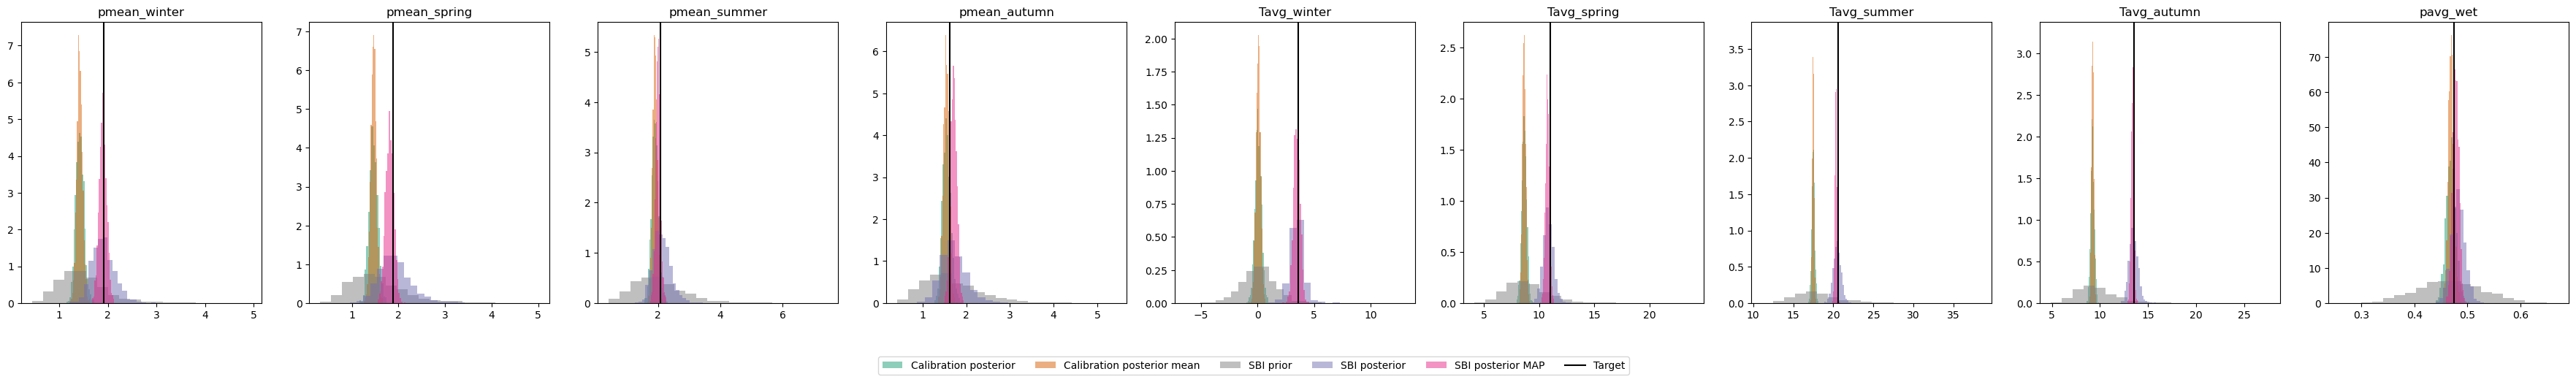

In [52]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_3c, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target_3c, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3c.pkl")

## Case study 3d (seasonal Tavg, pr)

In [53]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", "pavg_wet")
def case_study_3d(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn], axis = -1)#, icy_days])

obs_stats_3d = case_study_3d(
    t = svi_preds['t'][:, :, :, :], 
    prec = jnp.broadcast_to(obs['prec'], (svi_preds['t'].shape[0], obs['prec'].shape[1])),
    Tavg = jnp.broadcast_to(obs['Tavg'], (svi_preds['t'].shape[0], obs['Tavg'].shape[1]))
    ).mean(axis = 0).flatten()
obs_stats_3d

Array([ 1.4723729 ,  1.455283  ,  2.075413  ,  1.4105059 ,  0.17860313,
        8.4081745 , 17.47531   ,  9.037079  ], dtype=float32)

In [54]:
obs_stats_target_3d = obs_stats_3d
obs_stats_target_3d = obs_stats_target_3d.at[0].mul(1.3) # pmean winter
obs_stats_target_3d = obs_stats_target_3d.at[1].mul(1.3) # pmean spring
obs_stats_target_3d = obs_stats_target_3d.at[2].mul(1.) # pmean summer
obs_stats_target_3d = obs_stats_target_3d.at[3].mul(1.15) # pmean autumn

obs_stats_target_3d = obs_stats_target_3d.at[4].add(3.4) # Tavg winter
obs_stats_target_3d = obs_stats_target_3d.at[5].add(2.6) # Tavg spring
obs_stats_target_3d = obs_stats_target_3d.at[6].add(3.1) # Tavg summer
obs_stats_target_3d = obs_stats_target_3d.at[7].add(4.5) # Tavg autumn

obs_stats_target_3d

Array([ 1.9140847,  1.8918679,  2.075413 ,  1.6220818,  3.5786033,
       11.008175 , 20.57531  , 13.537079 ], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:28<00:00, 14.03s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.09s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.11s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 107 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 95 epochs.

INFO:wxsbi.wxsbi:Starting round 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 25

INFO:wxsbi.wxsbi:Starting round 5/10


 Neural network successfully converged after 26 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 44

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 45 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

INFO:wxsbi.wxsbi:Starting round 7/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 27

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 28 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 64

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 65 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 30

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 31 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.01s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.26s/it]


6.226984878381093


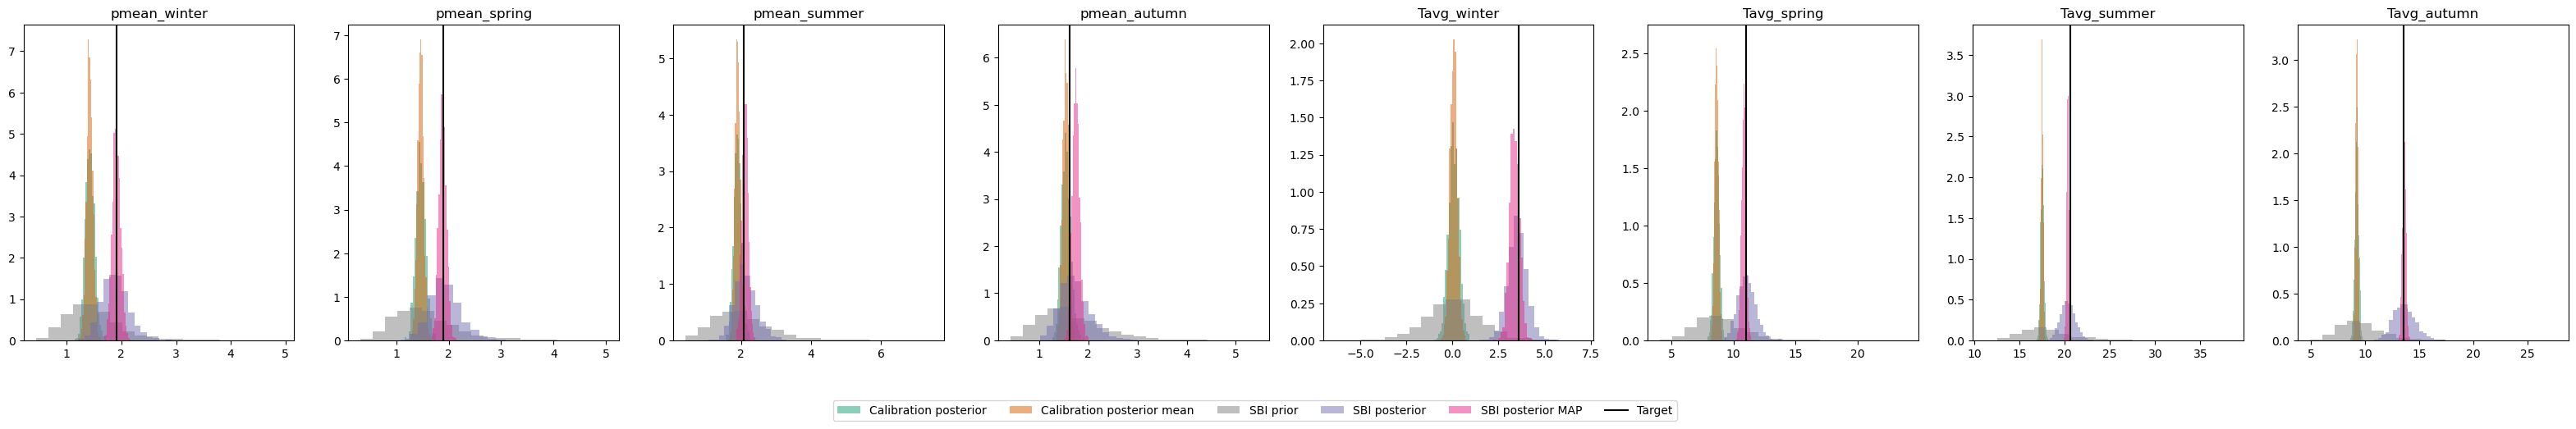

In [55]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_3d, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target_3d, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3d.pkl")

# Analysis

In [14]:
def prior_pred_corner_plot(sim_stats, obs_stats, target_stats, names, **sample_kwargs):
    """
    Create a prior predictive pair/corner diagnostic plot using the given simulated, observed, and target summary statistics.
    """
    df_prior = pd.DataFrame(sim_stats, columns=names)
    grid = sns.pairplot(df_prior, corner=True)
    for i in range(len(obs_stats)):
        for j in range(i+1, len(obs_stats)):
            grid.axes[j, i].scatter(obs_stats[i], obs_stats[j], color="black", marker="x", s=50.0, zorder=10)
            grid.axes[j, i].scatter(target_stats[i], target_stats[j], color="red", marker="*", s=50.0, zorder=10)
    return grid

## Case study 1

In [15]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_1a.pkl")

In [16]:
obs_stats_target_1a = result.summary_target
theta_prior, x_prior = result.simulate_from_sbi_prior(num_samples=300)
(theta_post, x_post), _ = result.simulate_from_sbi_posterior(num_samples=300)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Overview

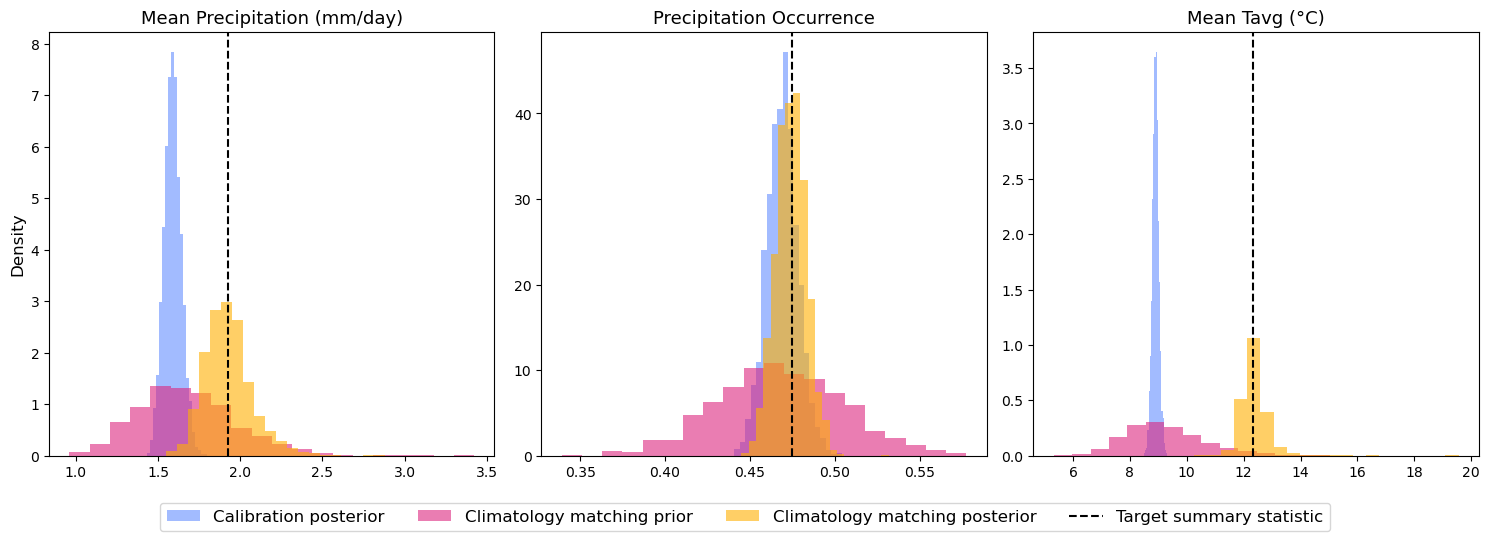

In [17]:
import matplotlib.pyplot as plt

# Colorblind-safe Paul Tol "Bright" palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

# Plot
titles = ["Mean Precipitation (mm/day)", "Precipitation Occurrence", "Mean Tavg (°C)"]

fig, axs = plt.subplots(
    1, obs_stats_target_1a.shape[0],
    figsize=(obs_stats_target_1a.shape[0] * 5, 5),
    layout="tight"
)

for i in range(obs_stats_target_1a.shape[0]):
    axs[i].hist(
        result.simulations["calibration_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["calibration_posterior"],
        label="Calibration posterior"
    )
    axs[i].hist(
        result.simulations["sbi_prior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["sbi_prior"],
        label="Climatology matching prior"
    )
    axs[i].hist(
        result.simulations["sbi_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["sbi_posterior"],
        label="Climatology matching posterior"
    )

    axs[i].axvline(
        obs_stats_target_1a[i],
        color="black", linestyle="--", linewidth=1.5,
        label="Target summary statistic"
    )

    axs[i].set_title(titles[i], fontsize=13)
    #axs[i].grid(alpha=0.3)

#axs[0].set_xlabel("Mean Precipitation (mm/day)", fontsize=12)
#axs[1].set_xlabel("Precipitation Occurrence", fontsize=12)
#axs[2].set_xlabel("Mean Tavg (°C)", fontsize=12)
axs[0].set_ylabel("Density", fontsize=12)
#axs[1].set_ylabel("Density", fontsize=12)
#axs[2].set_ylabel("Density", fontsize=12)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Shared legend below the plots, with box
fig.legend(
    by_label.values(), by_label.keys(),
    loc="upper center", bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=False, ncol=4, frameon=True,
    fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_1.png", dpi=300, bbox_inches="tight")
plt.savefig("plots/analysis_v2/case_study_1.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
ts = result.simulate_ts('sbi_posterior_map', 'calibration_posterior_mean', observables = ['prec', 'Tavg'], num_samples=10, from_parameter_samples = False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
obs_hist = ts["calibration_posterior_mean"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

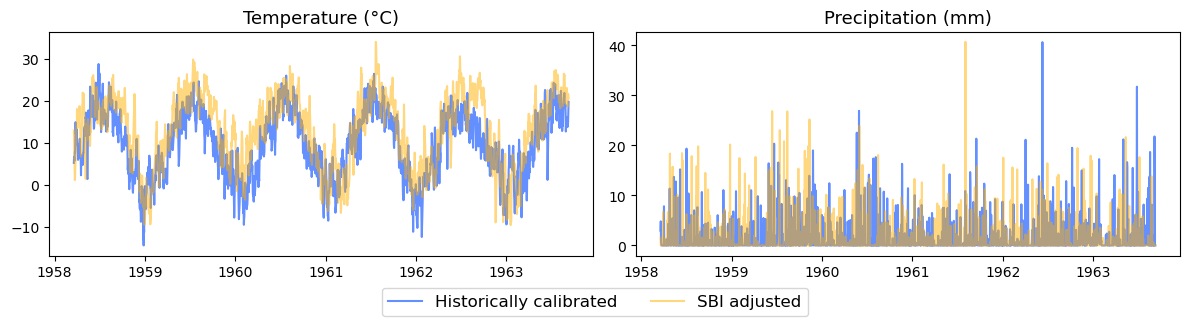

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 3), layout = "tight")

ax1.plot(calibration_data.index[3000:5000], tavg_hist[0, 3000:5000], label = "Historically calibrated", color = '#648FFF')
ax1.plot(calibration_data.index[3000:5000], tavg_fut[1, 3000:5000], alpha = 0.5, label = "SBI adjusted", color = '#FFB000')
ax1.set_title("Temperature (°C)", fontsize = 13)

ax2.plot(calibration_data.index[3000:5000], pr_hist[0, 3000:5000], color = '#648FFF')
ax2.plot(calibration_data.index[3000:5000], pr_fut[1, 3000:5000], alpha = 0.5, color = '#FFB000')
ax2.set_title("Precipitation (mm)", fontsize = 13)

fig.legend(loc="lower center", bbox_to_anchor = (0.5, -0.1), fontsize = 12, ncol=2)
fig.subplots_adjust(bottom=0.22)

plt.savefig("plots/analysis_v2/case_study_1_temp_precip.png", dpi = 300)
plt.savefig("plots/analysis_v2/case_study_1_temp_precip.pdf", dpi = 300)

### Simulation-based calibration

In [21]:
from sbi.diagnostics import run_sbc, check_sbc
from sbi.analysis.plot import sbc_rank_plot
from wxsbi.utils import j2t

In [22]:
thetas = theta_prior
xs = x_prior

In [23]:
ranks_all, dap_samples_all = run_sbc(j2t(thetas), j2t(xs), result.sbi_posterior)

/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/utils/diagnostics_utils.py:45: UserWarning: Capping max_sampling_batch_size from 10000 to 333 to avoid excessive memory usage.
  posterior_samples = posterior.sample_batched(


Drawing 1000 samples for 300 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 300 SBC samples:   0%|          | 0/300 [00:00<?, ?it/s]

In [24]:
ranks_lp, dap_samples_lp = run_sbc(j2t(thetas), j2t(xs), result.sbi_posterior, reduce_fns=result.sbi_posterior.log_prob)

Drawing 1000 samples for 300 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 300 SBC samples:   0%|          | 0/300 [00:00<?, ?it/s]

In [25]:
dap_samples_lp.shape

torch.Size([300, 126])

In [26]:
check_stats_all = check_sbc(ranks_all, j2t(thetas), dap_samples_all, num_posterior_samples=1000)
check_stats_all

{'ks_pvals': tensor([7.1068e-03, 3.2315e-02, 4.4751e-02, 3.2315e-02, 1.3500e-02, 2.1479e-02,
         3.8092e-02, 7.3266e-02, 2.9231e-02, 2.4665e-02, 5.5294e-01, 7.1068e-03,
         2.2062e-08, 1.7384e-02, 1.3500e-02, 1.3279e-01, 3.7886e-01, 2.0568e-01,
         1.0030e-02, 1.1589e-01, 4.3344e-02, 2.1078e-01, 2.1479e-02, 3.4112e-01,
         5.8411e-03, 7.7734e-02, 1.3014e-02, 2.2128e-01, 2.9231e-02, 5.9113e-01,
         3.1971e-01, 1.7384e-02, 2.4923e-01, 2.4344e-01, 9.6586e-03, 8.4867e-02,
         6.3038e-02, 1.6396e-01, 6.9797e-01, 3.9466e-01, 1.8664e-02, 1.1266e-03,
         6.3038e-02, 3.1955e-04, 5.8411e-03, 1.7705e-01, 1.9950e-03, 1.9107e-03,
         3.3541e-04, 4.3587e-01, 3.7493e-03, 3.0229e-02, 2.7322e-02, 6.2016e-01,
         6.8234e-04, 3.3388e-01, 9.2662e-01, 4.1086e-01, 2.2239e-02, 3.4112e-01,
         1.0283e-24, 7.5472e-02, 1.4010e-01, 7.1723e-01, 2.1739e-03, 2.6112e-01,
         1.7384e-02, 1.1912e-01, 3.6869e-02, 1.2319e-03, 6.3962e-01, 1.0964e-01,
         7.3266e

In [27]:
check_stats_lp = check_sbc(ranks_lp, j2t(thetas), dap_samples_lp, num_posterior_samples=1000)
check_stats_lp

{'ks_pvals': tensor([3.9019e-05]),
 'c2st_ranks': tensor([0.5000], dtype=torch.float64),
 'c2st_dap': tensor([0.5167, 0.5150, 0.4850, 0.5400, 0.5083, 0.5400, 0.5183, 0.4700, 0.5100,
         0.5100, 0.4700, 0.5667, 0.5200, 0.5183, 0.4650, 0.4983, 0.5350, 0.4883,
         0.5267, 0.4400, 0.5267, 0.4750, 0.4800, 0.5367, 0.5500, 0.5017, 0.4917,
         0.5083, 0.5300, 0.4900, 0.5200, 0.4783, 0.4633, 0.5033, 0.4683, 0.5467,
         0.5900, 0.4883, 0.5250, 0.4917, 0.5050, 0.5083, 0.5283, 0.5000, 0.5083,
         0.5017, 0.5033, 0.5267, 0.4817, 0.4700, 0.4850, 0.5250, 0.5167, 0.5133,
         0.4933, 0.4917, 0.4767, 0.5400, 0.5050, 0.5383, 0.5417, 0.4933, 0.5067,
         0.5183, 0.4967, 0.5167, 0.5167, 0.5000, 0.5200, 0.5633, 0.4783, 0.4817,
         0.5017, 0.5283, 0.4833, 0.5117, 0.4717, 0.5133, 0.5283, 0.4967, 0.4767,
         0.4550, 0.5100, 0.5100, 0.4950, 0.5083, 0.5117, 0.5117, 0.5217, 0.4900,
         0.5033, 0.4967, 0.5217, 0.5050, 0.4683, 0.4833, 0.4867, 0.4883, 0.5067,
        

(array([55.,  9., 11.,  5.,  8.,  6.,  5.,  4.,  4.,  2.,  2.,  1.,  2.,
         2.,  2.,  3.,  1.,  0.,  1.,  3.]),
 array([1.02831362e-24, 4.63307761e-02, 9.26615521e-02, 1.38992324e-01,
        1.85323104e-01, 2.31653884e-01, 2.77984649e-01, 3.24315429e-01,
        3.70646209e-01, 4.16976988e-01, 4.63307768e-01, 5.09638548e-01,
        5.55969298e-01, 6.02300107e-01, 6.48630857e-01, 6.94961667e-01,
        7.41292417e-01, 7.87623167e-01, 8.33953977e-01, 8.80284727e-01,
        9.26615536e-01]),
 <BarContainer object of 20 artists>)

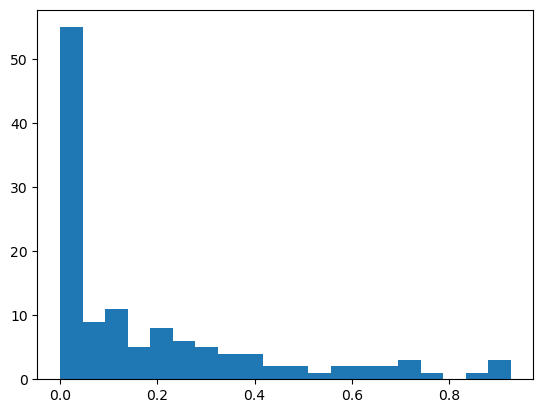

In [28]:
plt.hist(check_stats_all['ks_pvals'], bins=20)

In [29]:
# Calculate rejection rate of FDR of marginal KS tests under arbitrary dependence and Euler-Mascheroni constant = 0.57721
pvals_sorted, _ = check_stats_all['ks_pvals'].sort()
(pvals_sorted.cumsum(dim=0) < wxsbi.torch.arange(1, 127) / (126*(np.log(126) + 0.57721 + 1 / (2*126))) * 0.05).sum() / 126

tensor(0.0397)

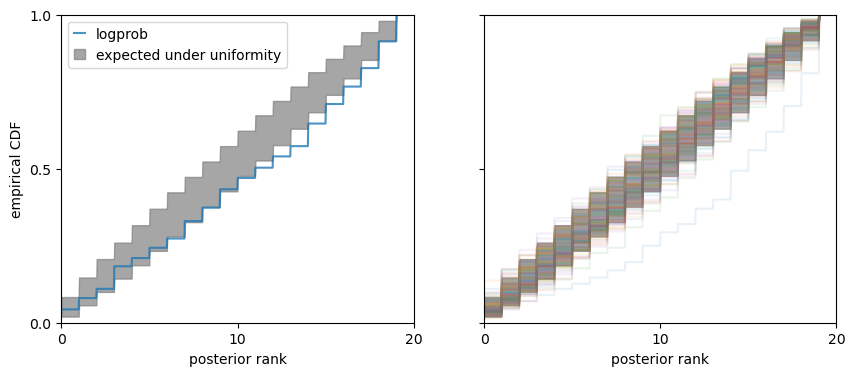

In [30]:
# create two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# draw each plot into the corresponding axes (if the function accepts ax=)
sbc_rank_plot(ranks_all, 1000, fig=fig, ax=axs[1], num_bins=20, uniform_region_alpha=0.7, line_alpha=0.1)
sbc_rank_plot(ranks_lp,  1000, fig=fig, ax=axs[0], parameter_labels=["logprob"], num_bins=20, uniform_region_alpha=0.7)
axs[1].get_legend().set_visible(False)
axs[1].set_ylabel("")
plt.savefig("plots/analysis_v2/sbc_case_study_1a_posterior_n=1.png", dpi=300)

In [31]:
hist_all = wxsbi.torch.stack([wxsbi.torch.histogram(ranks_all[:,i], 20)[0] for i in range(ranks_all.shape[1])], dim=1)
ecdf_all = hist_all.cumsum(dim=0)
ecdf_all = ecdf_all / ecdf_all.max(dim=0, keepdim=True)[0]
ecdf_all.shape

torch.Size([20, 126])

In [32]:
wgen_dist = wgen.as_distribution()
dummy_sample = wgen_dist.sample()*0

In [33]:
# get sorted list of parameters at midpoint of CDF
dummy_sample = dummy_sample.at[ecdf_all[10,:].argmax().item()].set(1)
wgen_dist.constrain(dummy_sample, as_dict=True)

OrderedDict([('Tavg_loc_lag', Array([-0., -0.], dtype=float32)),
             ('Tavg_loc_seasonal', Array([-0., -0., -0.,  0.], dtype=float32)),
             ('Tavg_loc_seasonal_lag_interaction',
              Array([-0.,  0.,  0.,  0., -0., -0., -0.,  0.], dtype=float32)),
             ('Tavg_loc_pred', Array([-0.], dtype=float32)),
             ('Tavg_loc_scale_seasonal',
              Array([-0.,  0., -0., -0.], dtype=float32)),
             ('Tavg_loc_scale_pred', Array([-0.], dtype=float32)),
             ('precip_occ_seasonal',
              Array([-0., -0., -0., -0.], dtype=float32)),
             ('precip_occ_lag', Array([-0.,  0.,  0.,  0.], dtype=float32)),
             ('precip_occ_lag_seasonal_interaction',
              Array([-0., -0.,  0., -0.,  0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,
                      0., -0.,  0.], dtype=float32)),
             ('precip_occ_Tavg', Array([-0.], dtype=float32)),
             ('precip_occ_Tavg_seasonal_interaction',
              

### Prior consistency checks

In [34]:
@wxsbi.summarystats("avg. precip", "precip freq", "avg. temperature")
def case_study_1a(prec, Tavg, **kwargs):
    pmean = jnp.mean(prec, axis = -1)
    pavgwet = jnp.mean(prec > 0, axis = -1)
    Tavgmean = jnp.mean(Tavg, axis = -1)
    return jnp.stack([pmean, pavgwet, Tavgmean], axis = -1)

In [35]:
obs_stats_1a = case_study_1a(**obs)

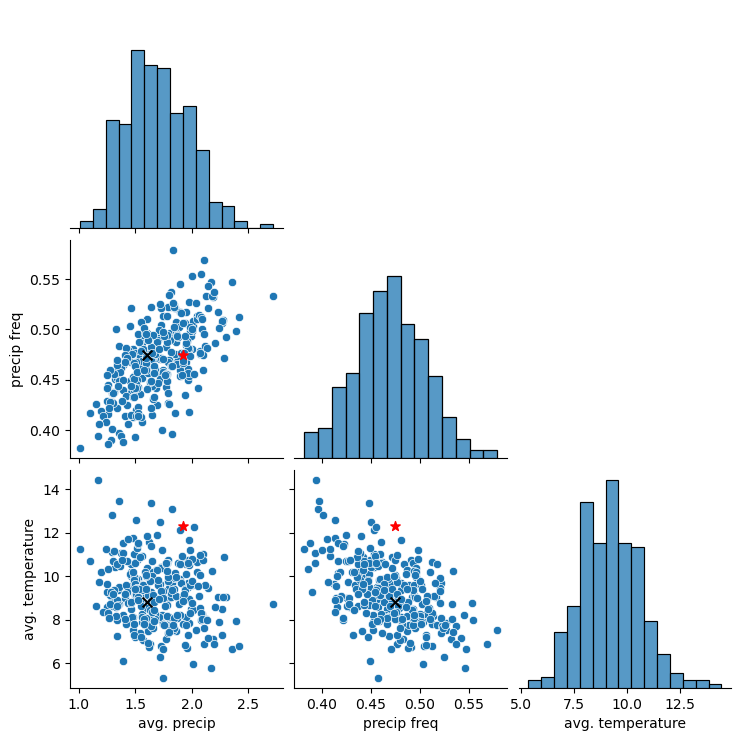

In [36]:
prior_pred_corner_plot(x_prior, obs_stats_1a, obs_stats_target_1a, case_study_1a.names)
plt.savefig("plots/analysis_v2/sbi_prior_pred_pair_plot_case_study_1a.pdf")

## Case study 2

In [37]:
@wxsbi.summarystats("Tavg: Mean", "Precipitation: Mean", "Heavy rain", "Icy days", "Tropical nights", "Trange: Mean")
def case_study_2(prec, Tmin, Tavg, Tmax, **kwargs):
    Tavgmean = jnp.mean(Tavg, axis = -1)
    
    pmean = jnp.mean(prec, axis = -1)
    heavy_rain = jnp.mean(prec > 20, axis = -1)

    icy_days = jnp.mean(Tmax < 0, axis = -1)
    tropical_nights = jnp.mean(Tmin > 20, axis = -1)

    Trangemean = jnp.mean(Tmax - Tmin, axis = -1)

    return jnp.stack([Tavgmean, pmean, heavy_rain, icy_days, tropical_nights, Trangemean], axis = -1)

In [38]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_2.pkl")

In [39]:
theta_prior, x_prior = result.simulate_from_sbi_prior(num_samples=300)
obs_stats_2 = case_study_2(**obs)
obs_stats_target_2 = result.summary_target

### Overview

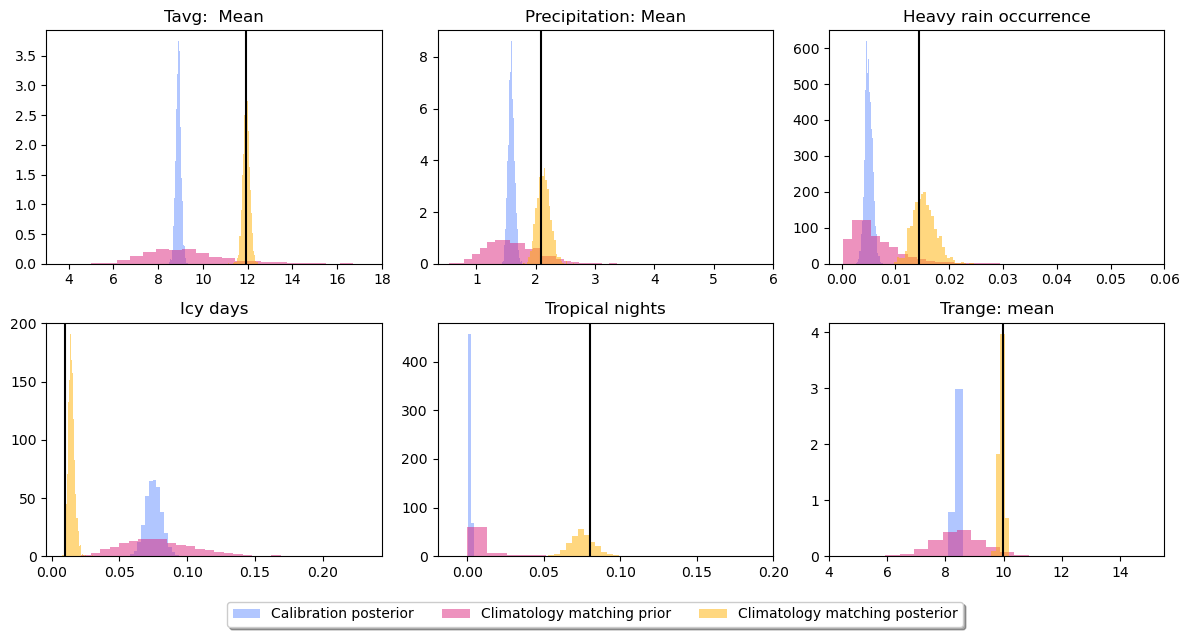

In [40]:
# Plot
colours = ["#648FFF", "#DC267F", "#FFB000"]

titles = ["Tavg:  Mean", "Precipitation: Mean", "Heavy rain occurrence", "Icy days", "Tropical nights", "Trange: mean"]
left_xlims = [3, None, None, None, None, 4]
right_xlims = [18, 6, 0.06, None, 0.2, None]

fig, axs = plt.subplots(2, 3, figsize = (12, 6), layout = "tight")
axs = axs.ravel()
for i in range(obs_stats_target_2.shape[0]):
    axs[i].hist(result.simulations["calibration_posterior"][:, i], bins = 30, density = True, alpha = 0.5, label = "Calibration posterior", color = colours[0])
    axs[i].hist(result.simulations["sbi_prior"][:, i], bins = 30, density = True, alpha = 0.5, label = "Climatology matching prior", color = colours[1])
    axs[i].hist(result.simulations["sbi_posterior"][:, i], bins = 30, density = True, alpha = 0.5, label = "Climatology matching posterior", color = colours[2])
    #axs[i].legend(loc = "upper right")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target_2[i].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.0),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("plots/analysis_v2/case_study_2.png", dpi = 300, bbox_inches='tight')
plt.savefig("plots/analysis_v2/case_study_2.pdf", dpi = 300, bbox_inches='tight')


### Prior consistency checks

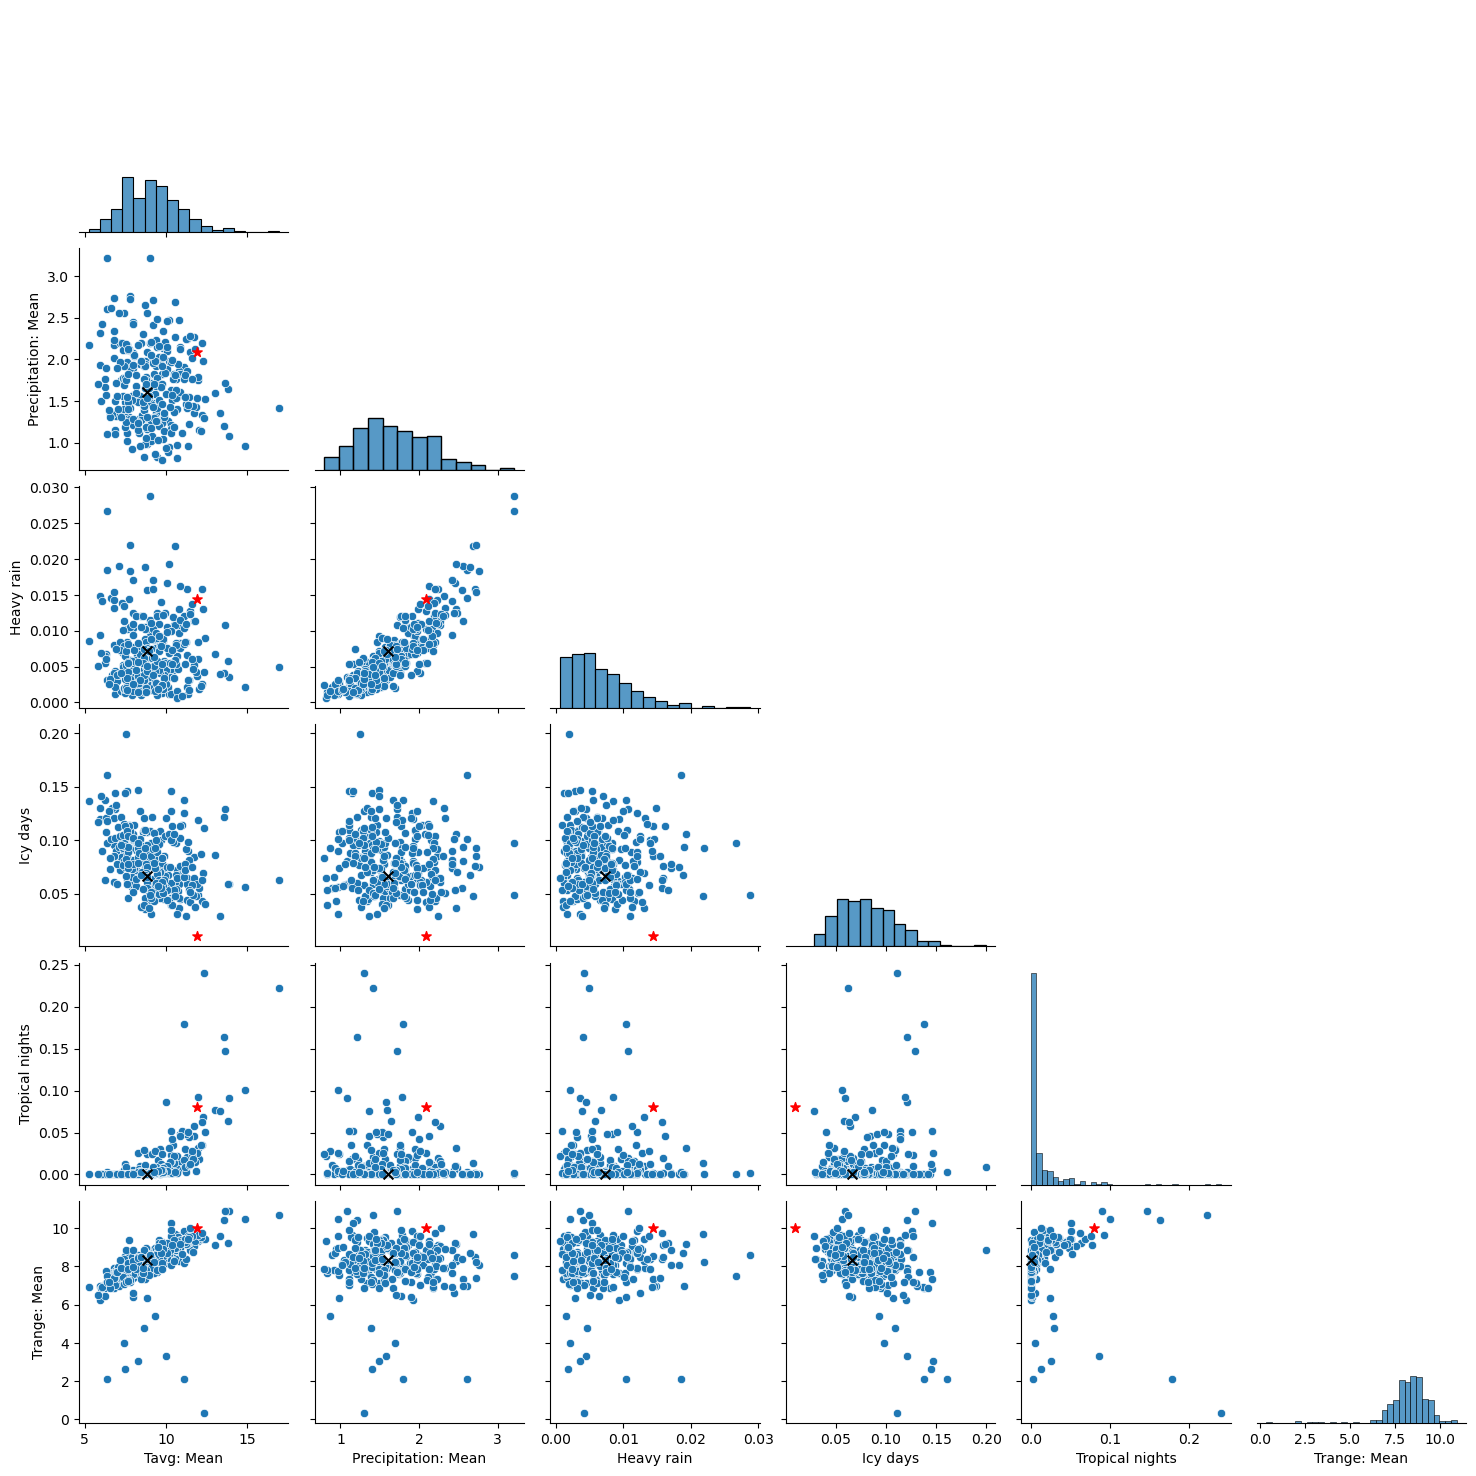

In [41]:
prior_pred_corner_plot(x_prior, obs_stats_2, obs_stats_target_2, case_study_2.names)
plt.savefig("plots/analysis_v2/sbi_prior_pred_pair_plot_case_study_2.pdf")

## Case study 3

### Overview part a)

In [42]:
result_3a = wxsbi.SBIResults.from_file("sbi_results/case_study_3a.pkl")
obs_stats_target_3a = result_3a.summary_target


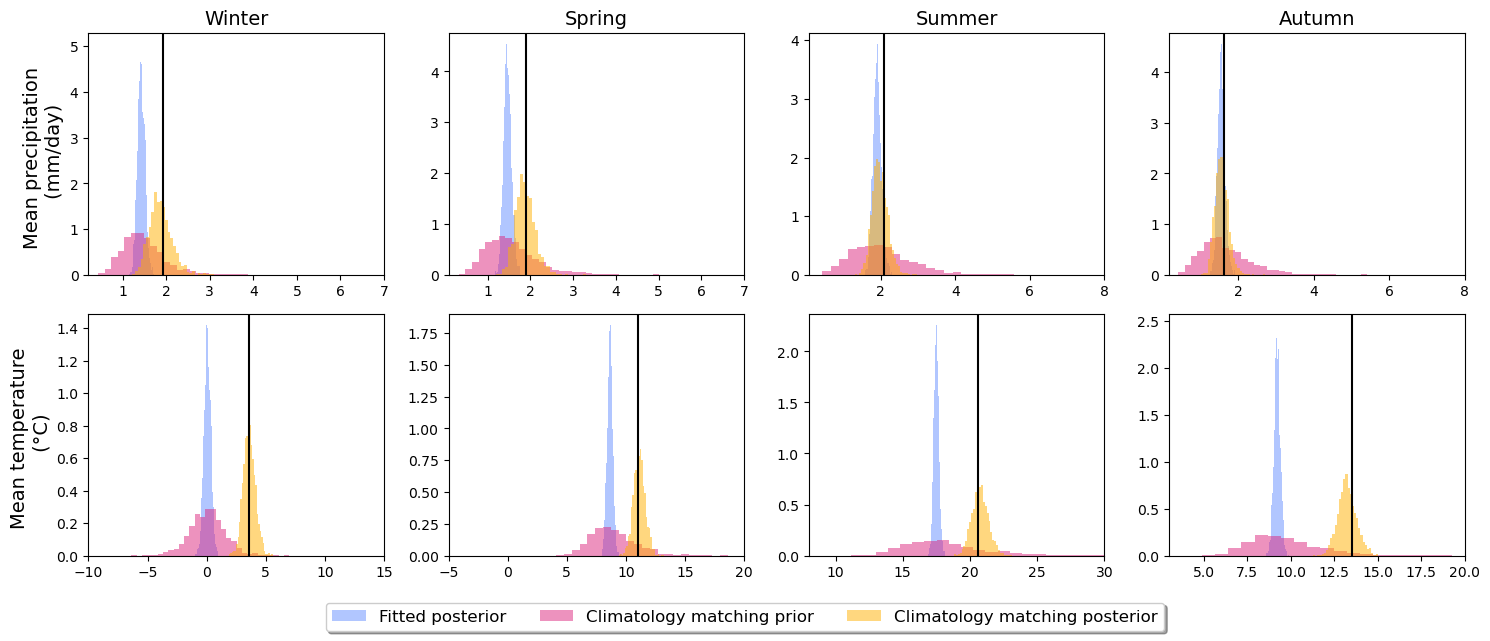

In [43]:
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result_3a.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result_3a.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result_3a.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target_3a[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3a.png", dpi=300, bbox_inches='tight')
plt.savefig("plots/analysis_v2/case_study_3a.pdf", dpi=300, bbox_inches='tight')

### Overview part b)

In [44]:
result_3b = wxsbi.SBIResults.from_file("sbi_results/case_study_3b.pkl")
obs_stats_target_3b = result_3b.summary_target


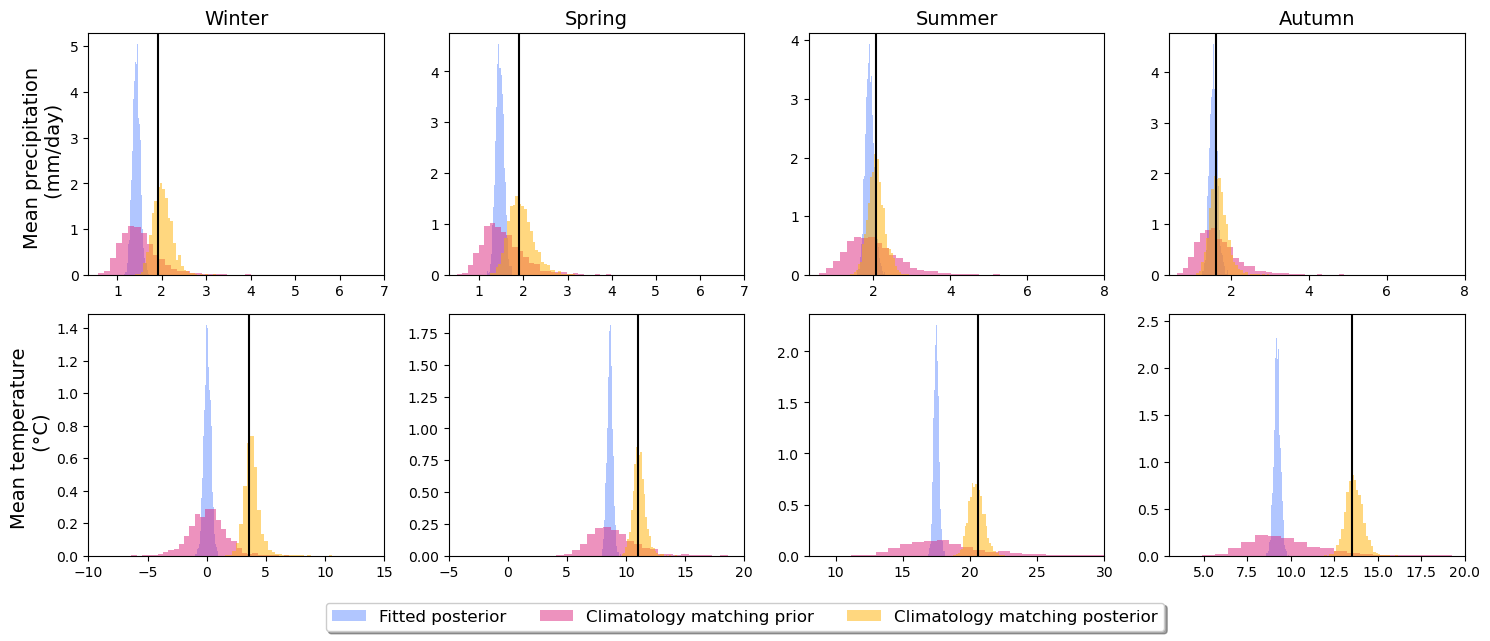

In [45]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result_3b.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result_3b.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result_3b.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target_3b[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3b.png", dpi=300, bbox_inches='tight')
plt.savefig("plots/analysis_v2/case_study_3b.pdf", dpi=300, bbox_inches='tight')

### Overview part c)

In [46]:
result_3c = wxsbi.SBIResults.from_file("sbi_results/case_study_3c.pkl")
obs_stats_target_3c = result_3c.summary_target


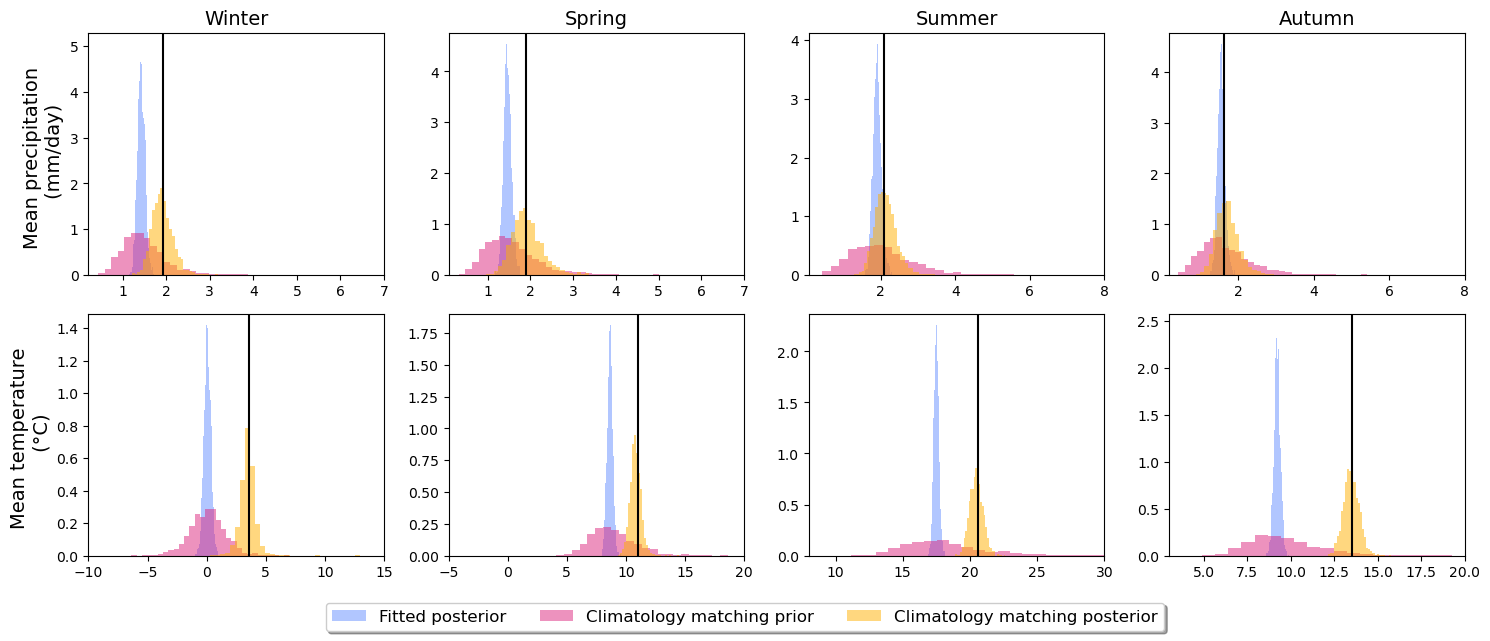

In [47]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result_3c.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result_3c.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result_3c.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target_3c[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3c.png", dpi=300, bbox_inches='tight')
plt.savefig("plots/analysis_v2/case_study_3c.pdf", dpi=300, bbox_inches='tight')

### Overview part d)

In [48]:
result_3d = wxsbi.SBIResults.from_file("sbi_results/case_study_3d.pkl")
obs_stats_target_3d = result_3d.summary_target


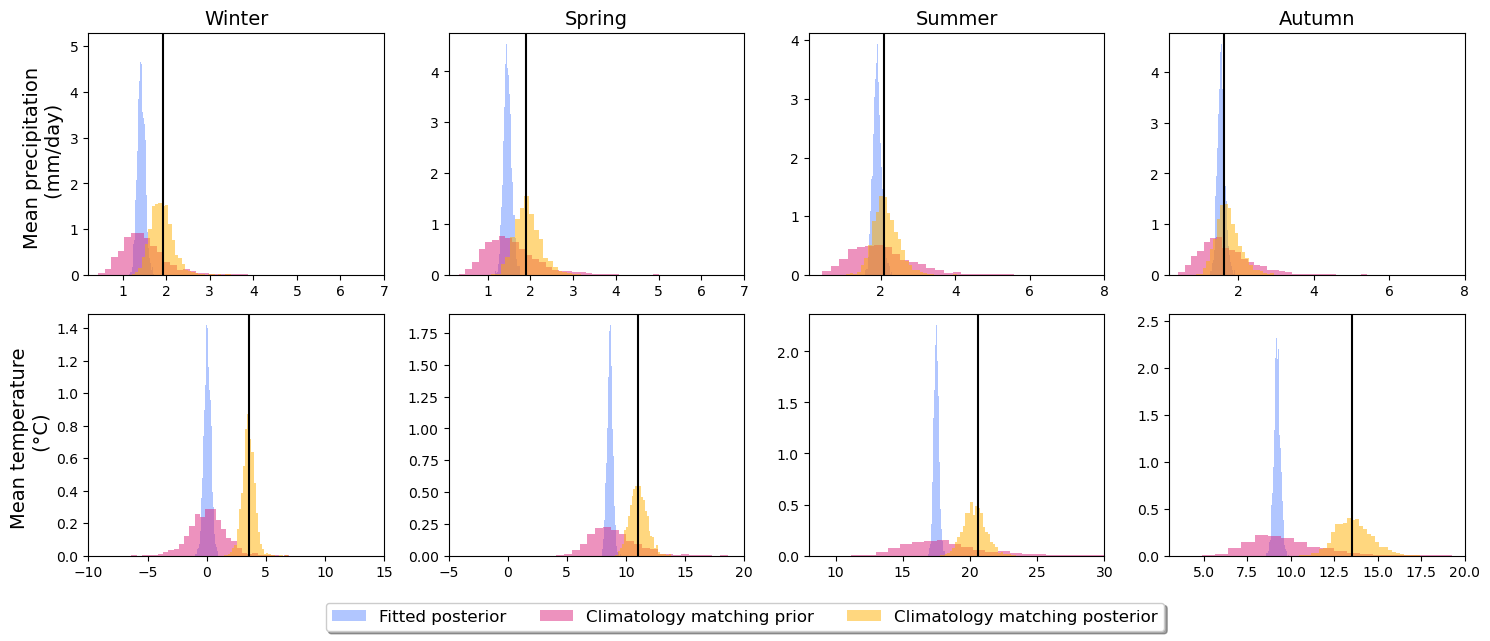

In [49]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result_3d.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result_3d.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result_3d.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target_3d[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3d.png", dpi=300, bbox_inches='tight')
plt.savefig("plots/analysis_v2/case_study_3d.pdf", dpi=300, bbox_inches='tight')

### Seasonal analysis

In [50]:
ts_3a = result_3a.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)
ts_3b = result_3b.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)
ts_3c = result_3c.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)
ts_3d = result_3d.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [51]:
def make_line_plots(fut, hist, obs, time, target = None, ax = None, color_fut = "lightblue"):
    if ax is None:
        fig, ax = plt.subplots(figsize = (6,4))
        
    df_preds = pd.DataFrame(fut.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = color_fut, alpha = 0.2, ax = ax)
    
    df_preds = pd.DataFrame(hist.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = "grey", alpha = 0.2, ax = ax)
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": calibration_data.index})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].mean().reset_index()
    sns.lineplot(df_obs, x="time", y="obs", color = "black", ax = ax)

    if target is not None:
        ax.axhline(target, color = "darkblue", linestyle = "dashed")

def add_seasonal_targets(targets, ax):
    ax.hlines(y = targets[0], xmin = 1, xmax = 2.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[1], xmin = 2.5, xmax = 5.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[2], xmin = 5.5, xmax = 8.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[3], xmin = 8.5, xmax = 11.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")

def add_monthly_targets(targets, ax):
    for i in range(2, 12):
        ax.hlines(y = targets[i-1], xmin = i-0.5, xmax = i+0.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 1, xmax = 1.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[11], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")


In [52]:
def plot_monthly_ensemble(model_hist, model_post, obs, axes, **kwargs):
    pr_hist, tavg_hist = model_hist['prec'][:, :, 0], model_hist['Tavg'][:, :, 0]
    pr_fut, tavg_fut = model_post['prec'][:, :, 0], model_post['Tavg'][:, :, 0]
    
    make_line_plots(pr_fut, pr_hist, obs["prec"], calibration_data.index, ax = axes[0])
    axes[0].set_title("Average precipitation (mm/day)", fontsize = 14)

    make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axes[1])
    axes[1].set_title("Precipitation occurrence", fontsize = 14)

    make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], calibration_data.index, ax = axes[2])
    axes[2].set_title("Average temperature (°C)", fontsize = 14)

    axes[0].set_xlabel("Month", fontsize = 12)
    axes[1].set_xlabel("Month", fontsize = 12)
    axes[2].set_xlabel("Month", fontsize = 12)
    axes[0].set_ylabel("")
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")

In [53]:
def plot_seasonal_targets_3a(target_stats, axes):
    add_seasonal_targets(target_stats[:4], axes[0])
    add_monthly_targets(target_stats[9:], axes[1])
    add_seasonal_targets(target_stats[4:9], axes[2])

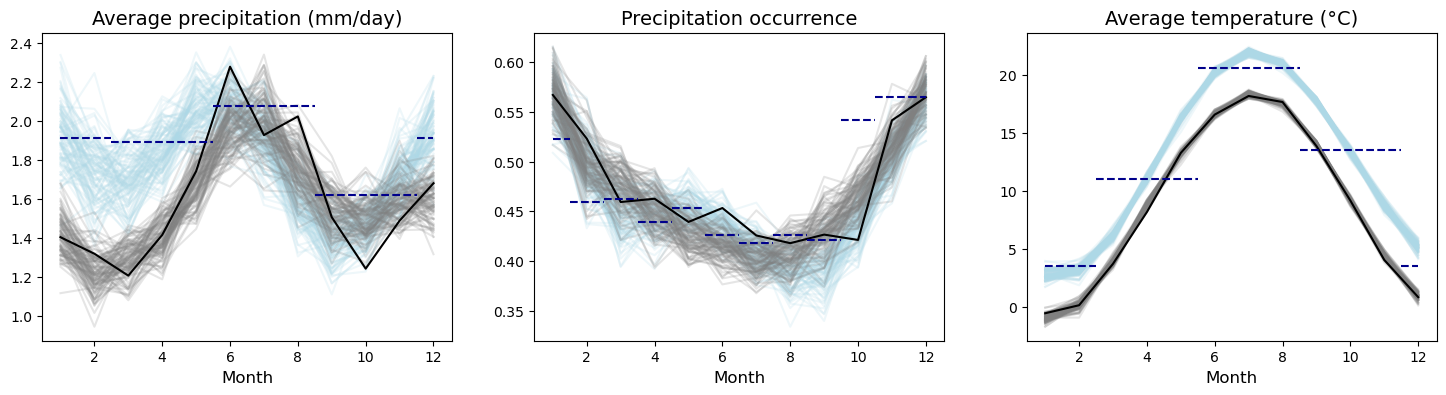

In [54]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
plot_monthly_ensemble(ts_3a["calibration_posterior"], ts_3a["sbi_posterior_map"], obs, axs)
plot_seasonal_targets_3a(obs_stats_target_3a, axs)
plt.savefig("plots/analysis_v2/case_study_3a_ensemble.png", dpi=300, bbox_inches='tight')

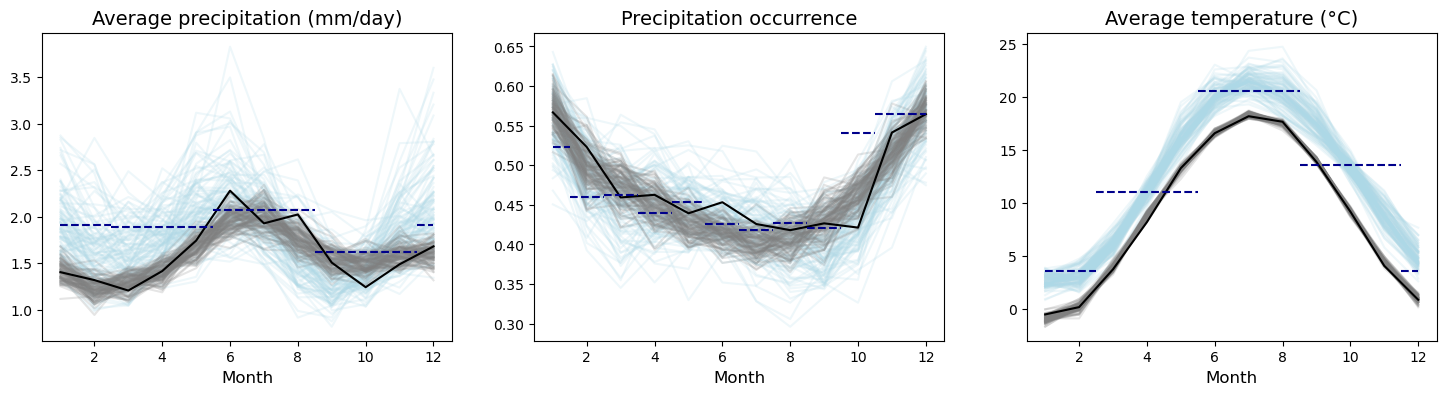

In [55]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
plot_monthly_ensemble(ts_3a["calibration_posterior"], ts_3a["sbi_posterior"], obs, axs)
plot_seasonal_targets_3a(obs_stats_target_3a, axs)
plt.savefig("plots/analysis_v2/case_study_3a_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

In [56]:
def plot_seasonal_targets_3b(target_stats, axes):
    add_seasonal_targets(target_stats[:4], axes[0])
    axes[1].axhline(target_stats[-1], color = "darkblue", linestyle = "dashed")
    add_seasonal_targets(target_stats[4:], axes[2])

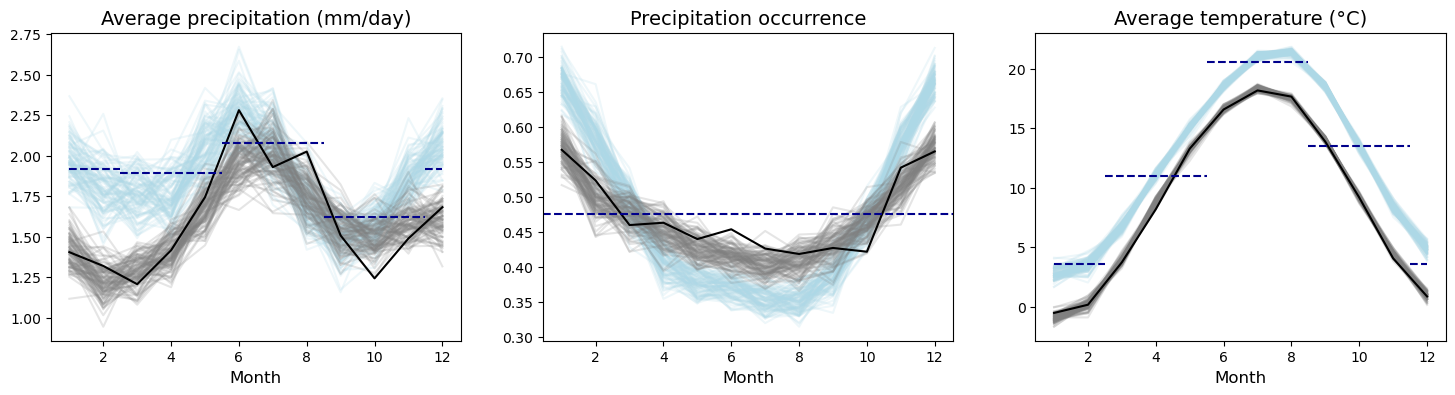

In [57]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
plot_monthly_ensemble(ts_3b["calibration_posterior"], ts_3b["sbi_posterior_map"], obs, axs)
plot_seasonal_targets_3b(obs_stats_target_3b, axs)
plt.savefig("plots/analysis_v2/case_study_3b_ensemble.png", dpi=300, bbox_inches='tight')

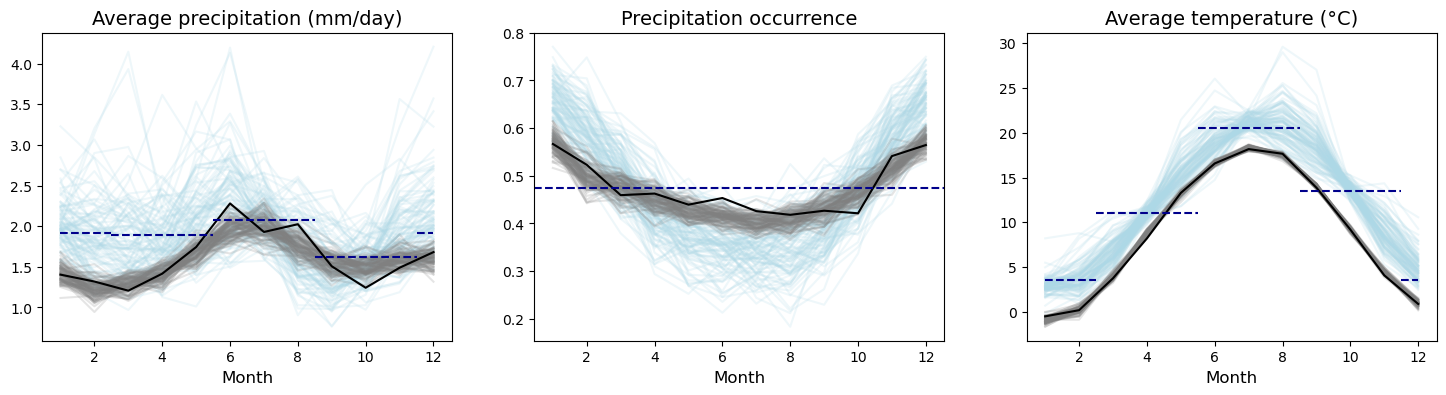

In [58]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
plot_monthly_ensemble(ts_3b["calibration_posterior"], ts_3b["sbi_posterior"], obs, axs)
plot_seasonal_targets_3b(obs_stats_target_3b, axs)
plt.savefig("plots/analysis_v2/case_study_3b_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

In [59]:
def plot_seasonal_targets_3c(target_stats, axes):
    add_seasonal_targets(target_stats[:4], axes[0])
    axes[1].axhline(target_stats[9], color = "darkblue", linestyle = "dashed")
    add_seasonal_targets(obs_stats_target_3c[4:], axes[2])

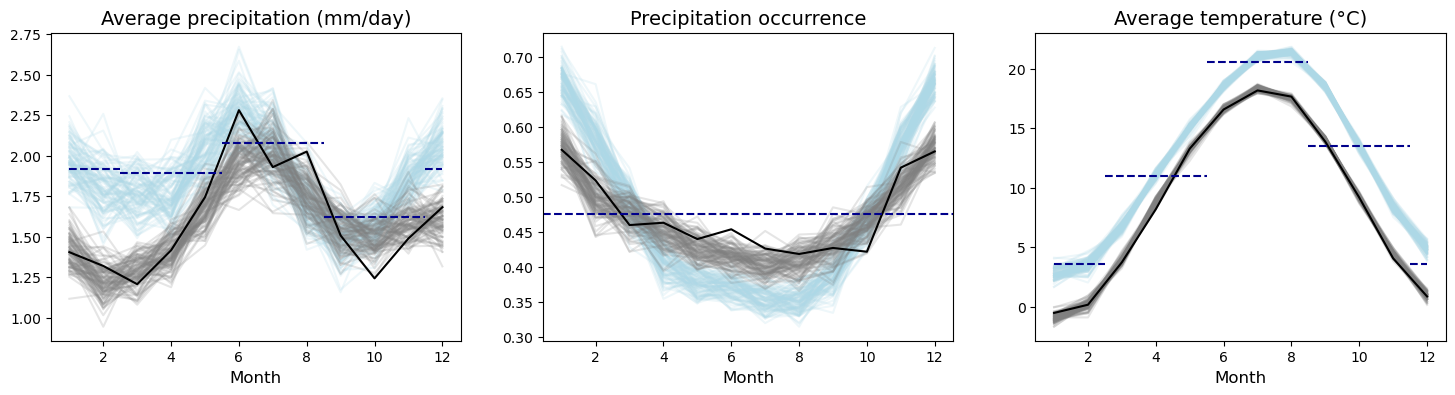

In [60]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
plot_monthly_ensemble(ts_3c["calibration_posterior"], ts_3b["sbi_posterior_map"], obs, axs)
plot_seasonal_targets_3c(obs_stats_target_3c, axs)
plt.savefig("plots/analysis_v2/case_study_3c_ensemble.png", dpi=300, bbox_inches='tight')

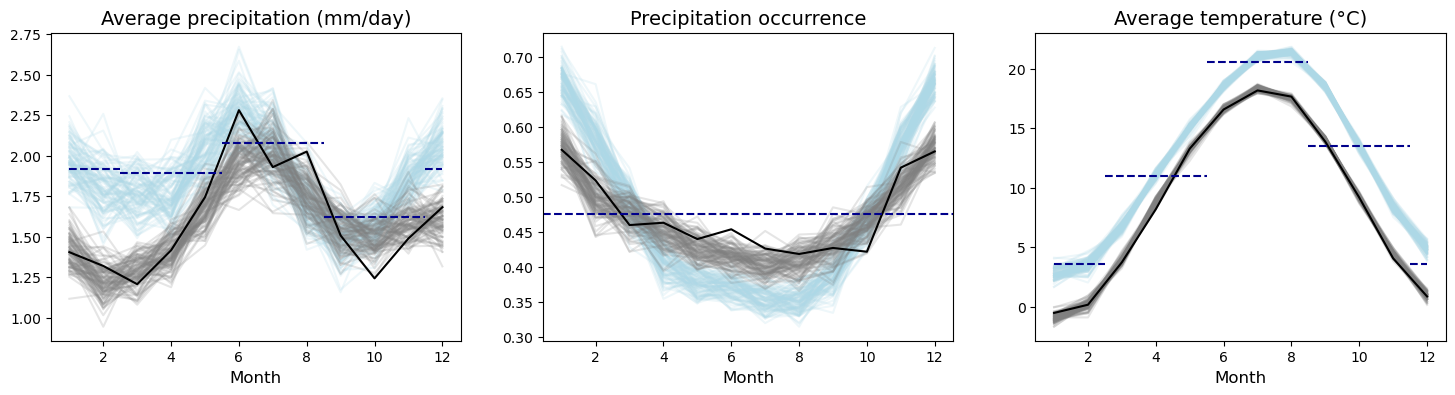

In [61]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
plot_monthly_ensemble(ts_3c["calibration_posterior"], ts_3b["sbi_posterior_map"], obs, axs)
plot_seasonal_targets_3c(obs_stats_target_3c, axs)
plt.savefig("plots/analysis_v2/case_study_3c_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

In [62]:
def plot_seasonal_targets_3d(target_stats, axes):
    add_seasonal_targets(target_stats[:4], axes[0])
    add_seasonal_targets(obs_stats_target_3c[4:], axes[2])

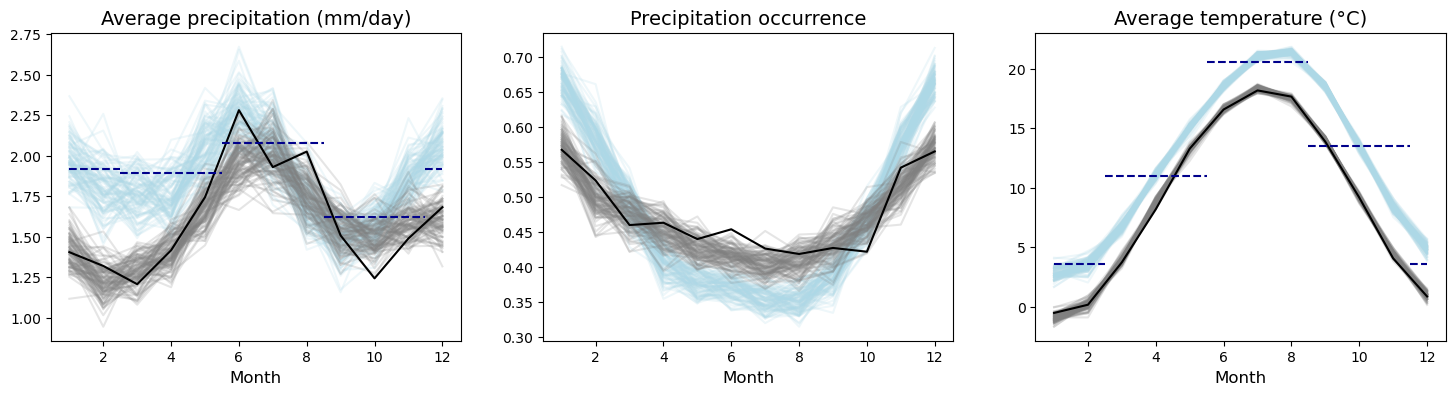

In [63]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
plot_monthly_ensemble(ts_3d["calibration_posterior"], ts_3b["sbi_posterior_map"], obs, axs)
plot_seasonal_targets_3d(obs_stats_target_3d, axs)
plt.savefig("plots/analysis_v2/case_study_3d_ensemble.png", dpi=300, bbox_inches='tight')

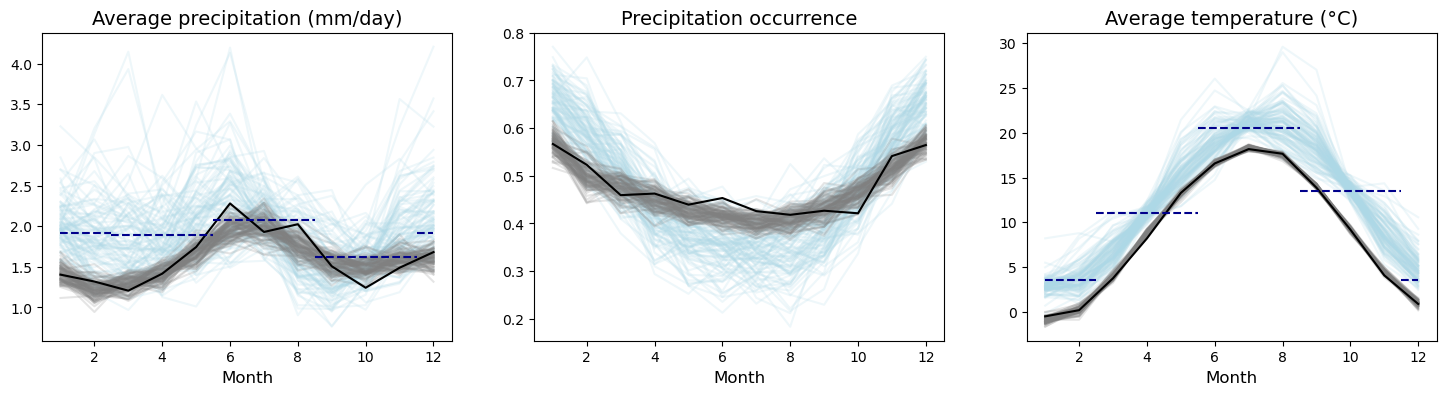

In [64]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
plot_monthly_ensemble(ts_3d["calibration_posterior"], ts_3b["sbi_posterior"], obs, axs)
plot_seasonal_targets_3d(obs_stats_target_3d, axs)
plt.savefig("plots/analysis_v2/case_study_3d_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

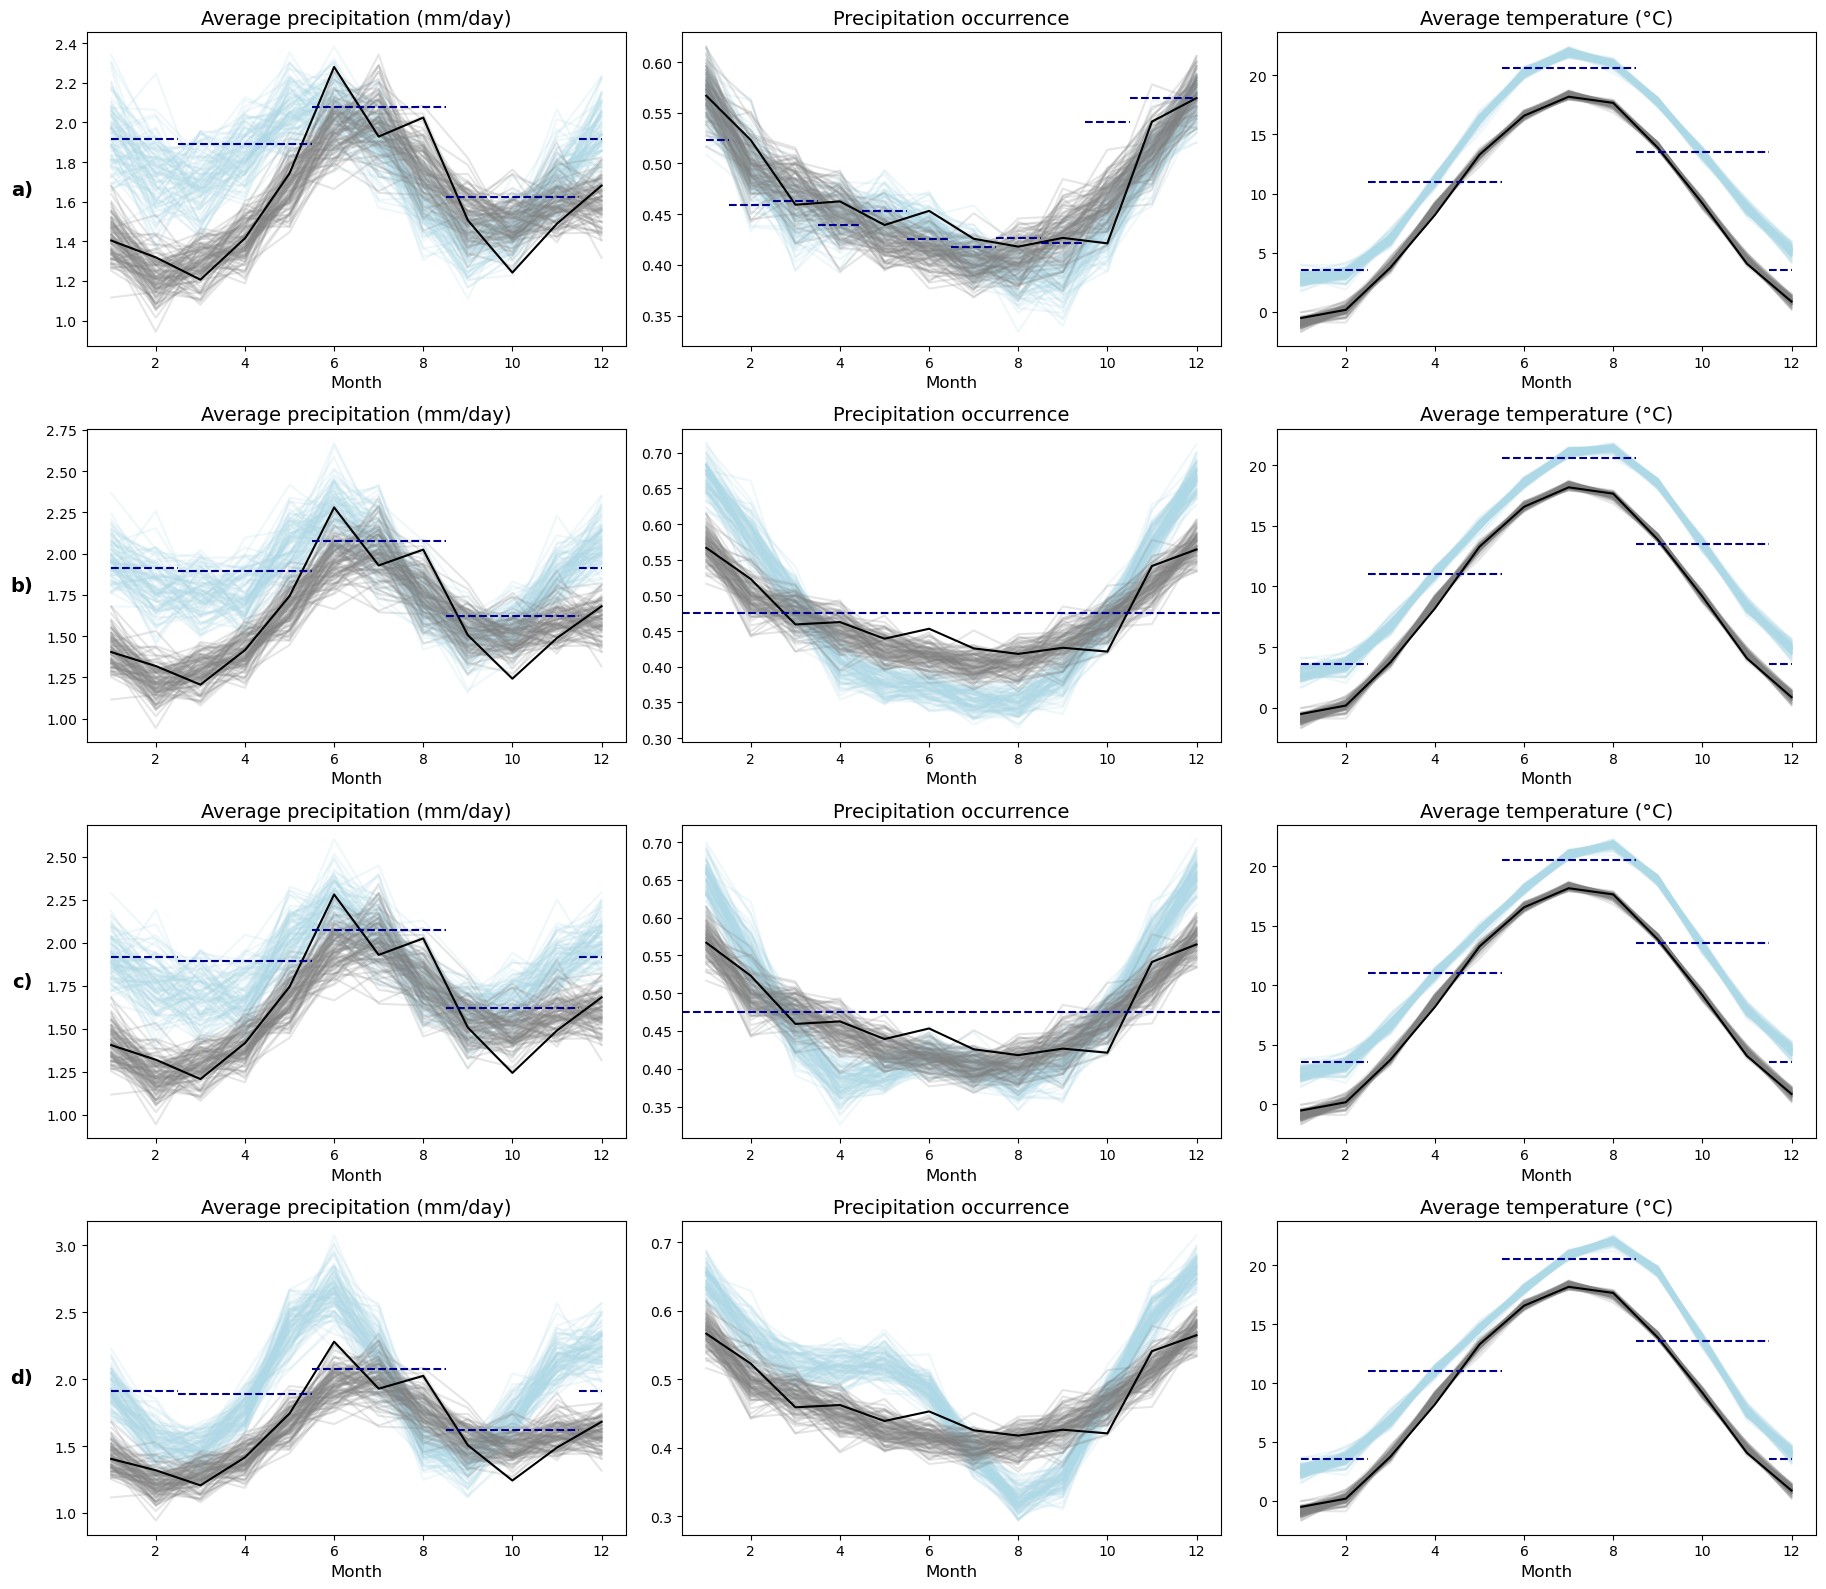

In [65]:
fig, axs = plt.subplots(4,3, figsize = (18,4*4))
plot_monthly_ensemble(ts_3a["calibration_posterior"], ts_3a["sbi_posterior_map"], obs, axs[0,:])
plot_seasonal_targets_3a(obs_stats_target_3a, axs[0,:])
plot_monthly_ensemble(ts_3b["calibration_posterior"], ts_3b["sbi_posterior_map"], obs, axs[1,:])
plot_seasonal_targets_3b(obs_stats_target_3b, axs[1,:])
plot_monthly_ensemble(ts_3c["calibration_posterior"], ts_3c["sbi_posterior_map"], obs, axs[2,:])
plot_seasonal_targets_3c(obs_stats_target_3c, axs[2,:])
plot_monthly_ensemble(ts_3d["calibration_posterior"], ts_3d["sbi_posterior_map"], obs, axs[3,:])
plot_seasonal_targets_3d(obs_stats_target_3d, axs[3,:])
plt.tight_layout()
# The following is generated by copilot:
# ensure layout is applied before reading axis positions
fig.canvas.draw()
# # add left-side row labels
row_labels = ["a)", "b)", "c)", "d)"]
for i, lab in enumerate(row_labels):
    pos = axs[i,0].get_position()           # bbox in figure coordinates
    fig.text(pos.x0 - 0.03,                 # slightly left of leftmost axis
             pos.y0 + pos.height/2,         # vertically centered on the row
             lab,
             fontsize=14, fontweight="bold",
             va="center", ha="right")
# save figure
plt.savefig("plots/analysis_v2/case_study_3_ensemble_all.pdf")
plt.show()

### Comparison of Climatology matching posterior for occurrence

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

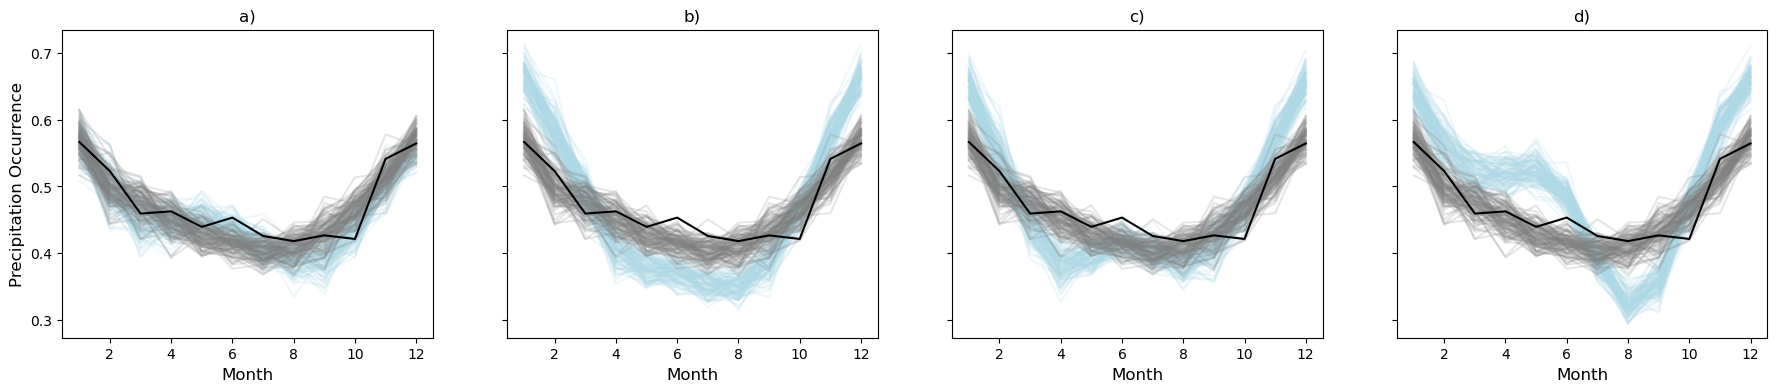

In [66]:
case_studies = ["3a", "3b", "3c", "3d"]
case_study_names = ["a)", "b)", "c)", "d)"]

fig, axs = plt.subplots(1,4, figsize = (22,4), sharey = True)

for i in range(4):

    case_study = case_studies[i]
    case_study_name = case_study_names[i]

    result = wxsbi.SBIResults.from_file(f"sbi_results/case_study_{case_study}.pkl")
    ts = result.simulate_ts('sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)
    
    obs_hist = ts["calibration_posterior"]
    obs_fut = ts["sbi_posterior_map"]

    pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
    pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

    make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[i])
    axs[i].set_title(case_study_name)
    axs[i].set_xlabel("Month", fontsize = 12)

axs[0].set_ylabel("Precipitation Occurrence", fontsize = 12)


    #fig.suptitle("Precipitation occurrence")

plt.savefig("plots/analysis_v2/case_study_3_occ_comparison.png", dpi=300, bbox_inches='tight')
plt.savefig("plots/analysis_v2/case_study_3_occ_comparison.pdf", dpi=300, bbox_inches='tight')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

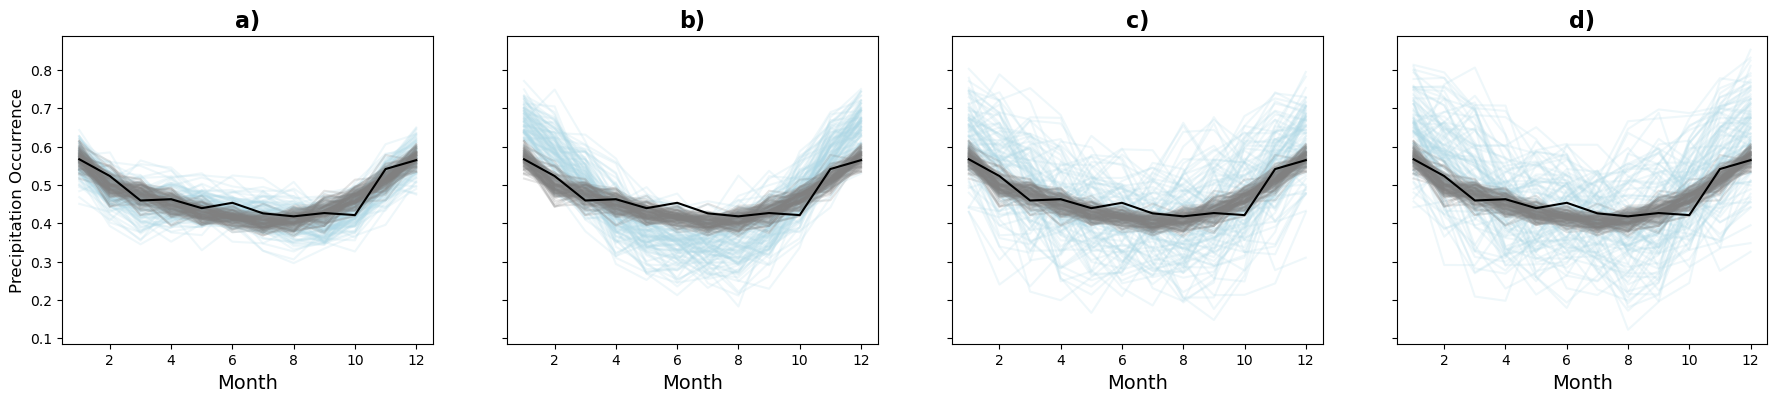

In [67]:
case_studies = ["3a", "3b", "3c", "3d"]
case_study_names = ["a)", "b)", "c)", "d)"]

fig, axs = plt.subplots(1,4, figsize = (22,4), sharey = True)

for i in range(4):

    case_study = case_studies[i]
    case_study_name = case_study_names[i]

    result = wxsbi.SBIResults.from_file(f"sbi_results/case_study_{case_study}.pkl")
    ts = result.simulate_ts('sbi_posterior', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)
    
    obs_hist = ts["calibration_posterior"]
    obs_fut = ts["sbi_posterior"]

    pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
    pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

    make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[i])
    axs[i].set_title(case_study_name, fontsize=16, fontweight="bold")
    axs[i].set_xlabel("Month", fontsize = 14)
axs[0].set_ylabel("Precipitation Occurrence", fontsize = 12)

    #fig.suptitle("Precipitation occurrence")

plt.savefig("plots/analysis_v2/case_study_3_occ_comparison_full_posterior.png", dpi=300, bbox_inches='tight')
plt.savefig("plots/analysis_v2/case_study_3_occ_comparison_full_posterior.pdf", dpi=300, bbox_inches='tight')

## Amortization Case study 1

In [68]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_1a.pkl")

Original: *1.2, +3.5
Case 1: *1.15, +3.0
Case 2: *1.25, +4.0

In [69]:
@wxsbi.summarystats("pmean", "pavgwet", "Tavgmean")
def case_study_1a(prec, Tavg, **kwargs):
    pmean = jnp.mean(prec, axis = -1)
    pavgwet = jnp.mean(prec > 0, axis = -1)
    Tavgmean = jnp.mean(Tavg, axis = -1)
    return jnp.stack([pmean, pavgwet, Tavgmean], axis = -1)

obs_stats = case_study_1a(**obs).flatten()

In [70]:
obs_stats_target1 = obs_stats
obs_stats_target1 = obs_stats_target1.at[0].mul(1.3)
obs_stats_target1 = obs_stats_target1.at[2].add(3.0)

obs_stats_target2 = obs_stats
obs_stats_target2 = obs_stats_target2.at[0].mul(1.1)
obs_stats_target2 = obs_stats_target2.at[2].add(4.0)
print(obs_stats, obs_stats_target1, obs_stats_target2)

[1.6045674 0.4748631 8.81644  ] [ 2.0859375  0.4748631 11.81644  ] [ 1.7650242  0.4748631 12.81644  ]


In [71]:
result1 = result.with_target(obs_stats_target1)
result2 = result.with_target(obs_stats_target2)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [72]:
obs_stats_target = result.summary_target

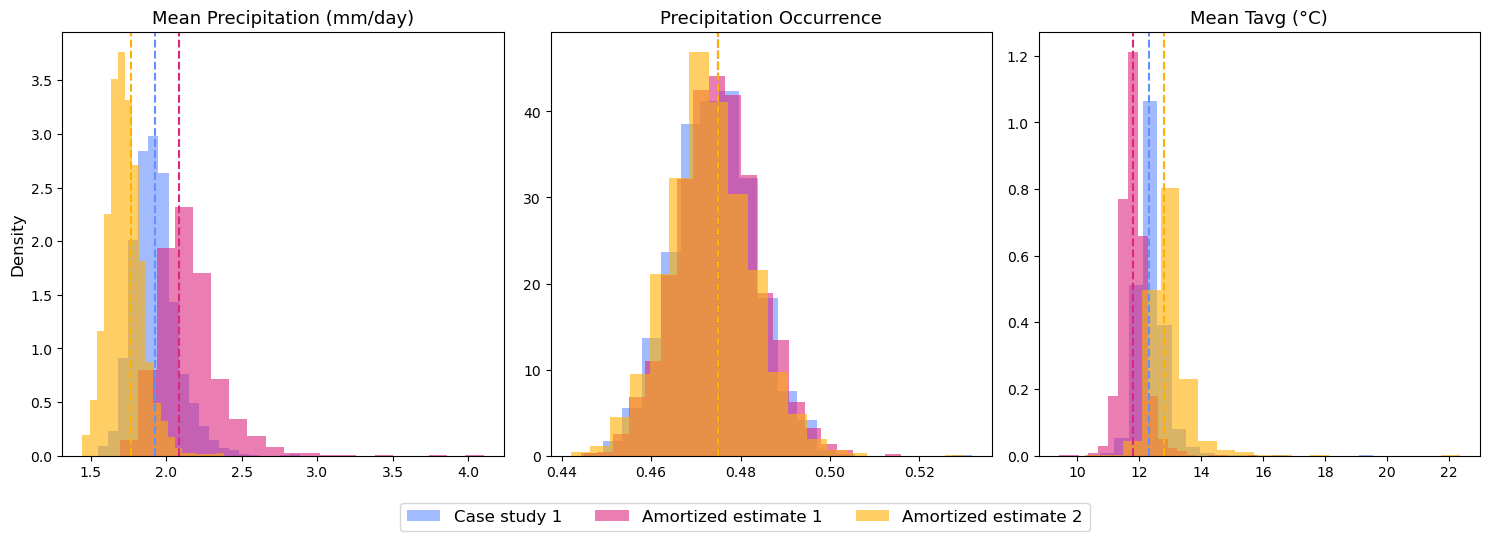

In [73]:
import matplotlib.pyplot as plt

# Colorblind-safe Paul Tol "Bright" palette
colors = {
    "result": "#648FFF",  # blue
    "result1": "#DC267F",              # magenta
    "result2": "#FFB000"           # orange
}

# Plot
titles = ["Mean Precipitation (mm/day)", "Precipitation Occurrence", "Mean Tavg (°C)"]

fig, axs = plt.subplots(
    1, obs_stats_target2.shape[0],
    figsize=(obs_stats_target2.shape[0] * 5, 5),
    layout="tight"
)

for i in range(obs_stats_target2.shape[0]):
    axs[i].hist(
        result.simulations["sbi_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["result"],
        label="Case study 1"
    )
    axs[i].hist(
        result1.simulations["sbi_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["result1"],
        label="Amortized estimate 1"
    )
    axs[i].hist(
        result2.simulations["sbi_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["result2"],
        label="Amortized estimate 2"
    )

    axs[i].axvline(
        obs_stats_target[i],
        color=colors["result"], linestyle="--", linewidth=1.5,
    )
    axs[i].axvline(
        obs_stats_target1[i],
        color=colors["result1"], linestyle="--", linewidth=1.5,
    )
    axs[i].axvline(
        obs_stats_target2[i],
        color=colors["result2"], linestyle="--", linewidth=1.5,
    )

    axs[i].set_title(titles[i], fontsize=13)
    #axs[i].grid(alpha=0.3)

#axs[0].set_xlabel("Mean Precipitation (mm/day)", fontsize=12)
#axs[1].set_xlabel("Precipitation Occurrence", fontsize=12)
#axs[2].set_xlabel("Mean Tavg (°C)", fontsize=12)
axs[0].set_ylabel("Density", fontsize=12)
#axs[1].set_ylabel("Density", fontsize=12)
#axs[2].set_ylabel("Density", fontsize=12)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Shared legend below the plots, with box
fig.legend(
    by_label.values(), by_label.keys(),
    loc="upper center", bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=False, ncol=4, frameon=True,
    fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_1_amortization.png", dpi=300, bbox_inches="tight")
plt.savefig("plots/analysis_v2/case_study_1_amortization.pdf", dpi=300, bbox_inches="tight")
plt.show()

## Model/target misspecification

In [74]:
@wxsbi.summarystats("Precipitation: Mean", "Precipitation Occurrence", "Cumulative Dry Days", "Tavg: Mean")
def test_stats(prec, Tavg, **kwargs):
    pmean = jnp.mean(prec, axis = -1)
    pavgwet = jnp.mean(prec > 0, axis = -1)
    cdd = weathergen.utils.cumulative_dry_days(prec, axis=-1)
    Tavgmean = jnp.mean(Tavg, axis = -1)
    return jnp.stack([pmean, pavgwet, cdd, Tavgmean], axis = -1)

In [75]:
obs_stats_test = test_stats(**obs)
obs_stats_test

Array([1.6045674, 0.4748631, 3.149097 , 8.81644  ], dtype=float32)

In [76]:
simulator_test = wxsbi.build_simulator(wgen, test_stats, parallel = True)
cm_prior_test = wxsbi.get_rescaled_svi_posterior(guide, svi_result, scale_factor=2.5)

In [77]:
theta_prior, x_prior = wxsbi.simulate_from_sbi_prior(simulator_test, cm_prior_test)

In [78]:
df_test = pd.DataFrame(x_prior, columns=test_stats.names)
df_test

Precipitation: Mean  Precipitation Occurrence  Cumulative Dry Days  \
0               1.311288                  0.406462             4.485927   
1               1.815320                  0.513417             2.794025   
2               1.425184                  0.384064             4.089818   
3               1.506813                  0.531052             2.826073   
4               1.856260                  0.470372             3.117666   
..                   ...                       ...                  ...   
995             1.695960                  0.448193             3.314474   
996             2.123712                  0.538719             2.814233   
997             1.629993                  0.565444             2.523052   
998             1.583647                  0.523713             2.820954   
999             1.699897                  0.538226             2.734998   

     Tavg: Mean  
0     10.015497  
1      7.964441  
2     10.922936  
3      8.731818  
4      5.948962  
..          ...  
995   11.116910  
996    8.245821  
997    8.908271  
998    8.657867  
999    8.679549  

[1000 rows x 4 columns]

- Increase average precip by 10%
- Increase precip frequency by 30%
- Incrase cumulative dry days by 30%; this is inconsistent with the previous two changes since it implies drier conditons.

In [79]:
obs_stats_target_test = obs_stats_test
obs_stats_target_test = obs_stats_target_test.at[0].mul(1.1)
obs_stats_target_test = obs_stats_target_test.at[1].mul(1.3)
obs_stats_target_test = obs_stats_target_test.at[2].mul(1.3)
obs_stats_target_test

Array([1.7650242, 0.617322 , 4.093826 , 8.81644  ], dtype=float32)

As expected, the anomaly can be seen in the pair plot for CDD and precip occurrence.

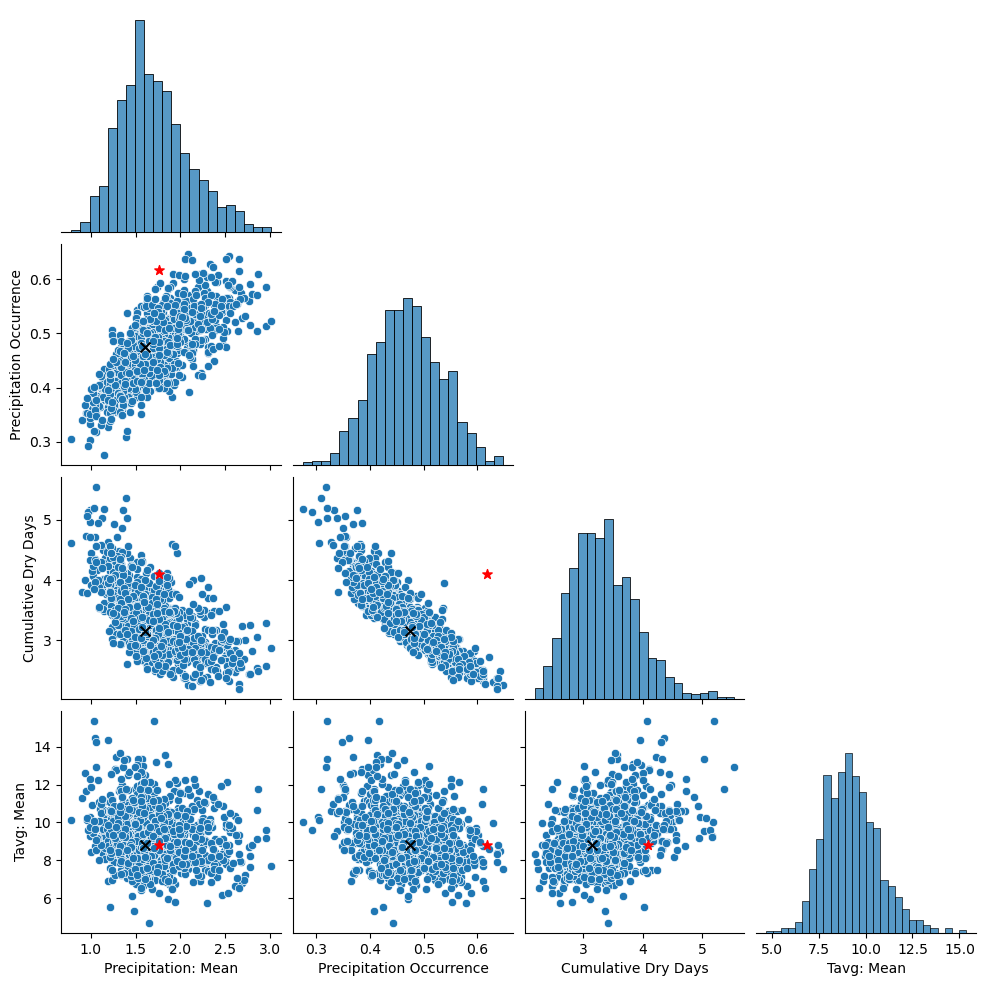

In [81]:
prior_pred_corner_plot(x_prior, obs_stats_test, obs_stats_target_test, test_stats.names)
plt.savefig("plots/analysis_v2/sbi_prior_pred_pair_plot_mis.pdf")